# EIT Continuous Model Complex-Valued Tests

This work aims to set first tests with EIT implementantion using FENICSx library, aiming to solve the complex valued case, explaining some of the fundamentals in the library implementation. In this context, we will be using the Continuous Model, testing initially with trivial simulated functions and simple meshes, adding more information and complexity as advancing.

More information and explanations about some steps can be seen in the FENICSx tutorial: https://jsdokken.com/dolfinx-tutorial/chapter1/complex_mode.html.

# Implementation - Direct Problem



## Importing

Run the following blocks to install and import all the libraries required.

In [6]:
try:
    import gmsh
except ImportError:
    !wget "https://github.com/fem-on-colab/fem-on-colab.github.io/raw/75de0a3/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh

try:
    import dolfinx
except ImportError:
  !wget "https://github.com/fem-on-colab/fem-on-colab.github.io/raw/75de0a3/releases/fenicsx-install-complex.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
  import dolfinx

try:
    import pyvista
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/vtk-install.sh" -O "/tmp/vtk-install.sh" && bash "/tmp/vtk-install.sh"
    import pyvista

pyvista.set_jupyter_backend("static")

import sys
import dolfinx
from mpi4py import MPI #import parallel communicator
import numpy as np
import ufl
import matplotlib.pyplot as plt
import dolfinx.fem.petsc
from dolfinx.io import gmshio
import time
import pandas as pd

print("Python version: ", sys.version)
print(f"DOLFINx version: {dolfinx.__version__} based on GIT commit: {dolfinx.git_commit_hash} of https://github.com/FEniCS/dolfinx/")


#Check type of number set in PETSc lib, returns error if not complex
from petsc4py import PETSc #Linear algebra lib
print(PETSc.ScalarType)
assert np.dtype(PETSc.ScalarType).kind == 'c'

Python version:  3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
DOLFINx version: 0.8.0.0 based on GIT commit: 230e027269c0b872c6649f053e734ed7f49b6962 of https://github.com/FEniCS/dolfinx/
<class 'numpy.complex128'>


## Setup

The block below sums up all the setup info and auxiliary functions used for solving the problem. Details and discuss on implementations are listed in the notes and code blocks along the archive.

In [7]:
# trecho do código do Eduardo
class electrodes_position():
    """
    Object that contains the position of the electrodes in the boundary.
    The position is stored as the initial and final angles of each electrode.

    :param L: Number of electrodes.
    :type L: int
    :param per_cober: Percentual covered length in the boundary by electrodes, between 0 and 1.
    :type per_cober: float
    :param rotate: Rotation angle in the original solution for electrodes (in radians).
    :type rotate: float
    :param anticlockwise: If True, the electrodes are positioned anticlockwise, else clockwise.
    :type anticlockwise: bool, optional (default is True)
    """

    def __init__(self, L, per_cober, rotate, anticlockwise=True):
        #Checks
        if not isinstance(L, int): raise ValueError("Number of electrodes must be an integer.")
        if not isinstance(per_cober, float): raise ValueError("per_cober must be a float.")
        if not isinstance(rotate, (int, float)): raise ValueError("rotate must be a float.")
        if not isinstance(anticlockwise, bool): raise ValueError("anticlockwise must be true of false.")
        if per_cober>1: raise ValueError("per_cober must be equal or less than 1. Example (75%): per_cober=0.75 ")

        self.rotate=rotate
        self.L=L
        self.per_cober=per_cober
        self.anticlockwise=anticlockwise

        self.position=self.calc_position()
        self.coordinates = [((np.cos(electrode[0]),np.sin(electrode[0])), (np.cos(electrode[1]),np.sin(electrode[1]))) for electrode in self.position]


    def calc_position(self):
        """
        Calculate the position of electrodes based on the :class:`electrodes_position` object.

        :returns: list of arrays -- Returns a list with angle initial and final of each electrode.
        """
        size_e=2*np.pi/self.L*self.per_cober       #Size electrodes
        size_gap=2*np.pi/self.L*(1-self.per_cober) #Size gaps
        rotate=self.rotate                      #Rotating original solution

        electrodes=[]
        for i in range(self.L):
            #Example electrodes=[[0, pi/4], [pi/2, pi]]
            electrodes.append([size_e*i+size_gap*i+rotate, size_e*(i+1)+size_gap*i+rotate]) #Grouping angular values for electrodes.
        if not self.anticlockwise:
            electrodes[1:] = electrodes[1:][::-1] #Keep first electrode and reverse order
        return electrodes


def setupMesh(electrodes,mesh_refining=1,bdr_refining=1):
  # if running again, you must remove the comment in the following
  gmsh.finalize()
  gmsh.initialize()
  disk = gmsh.model.occ.addDisk(0, 0, 0, 1, 1) #creates disk centered in (0,0,0) with axis (1,1)

  #create point list for electrodes.
  #primeiro, do jeito gambiarrento -
  electrodes_points = []
  for electrode in electrodes.position:
    theta_array = np.linspace(electrode[0],electrode[1],)
    electrodes_points.extend([gmsh.model.occ.addPoint(np.cos(theta),np.sin(theta),0) for theta in theta_array])

  gmsh.model.occ.synchronize()
  gdim = 2 #variable to control disk dimension, where 2 stands for surface
  gmsh.model.addPhysicalGroup(gdim, [disk], 1) # starts mesh object
  # gmsh.model.addPhysicalGroup(0, electrodes_points, 2) #electrodes

  gmsh.option.setNumber("Mesh.CharacteristicLengthMax",0.2 * mesh_refining) # control max length of cells
  gmsh.model.mesh.field.add("Distance", 1)
  gmsh.model.mesh.field.setNumbers(1, "PointsList", electrodes_points)
  gmsh.model.mesh.field.add("Threshold", 2)
  gmsh.model.mesh.field.setNumber(2, "InField", 1)
  gmsh.model.mesh.field.setNumber(2, "SizeMin", 0.03 * bdr_refining)
  gmsh.model.mesh.field.setNumber(2, "SizeMax", 0.25 * bdr_refining )
  gmsh.model.mesh.field.setNumber(2, "DistMin", 0.075 * bdr_refining )
  gmsh.model.mesh.field.setNumber(2, "DistMax", 0.1 * bdr_refining)
  gmsh.model.mesh.field.add("Min", 3)
  gmsh.model.mesh.field.setNumbers(3, "FieldsList", [2])
  gmsh.model.mesh.field.setAsBackgroundMesh(3)
  gmsh.option.setNumber("Mesh.MeshSizeExtendFromBoundary", 0)
  gmsh.option.setNumber("Mesh.MeshSizeFromPoints", 0)
  gmsh.option.setNumber("Mesh.MeshSizeFromCurvature", 0)
  gmsh.model.mesh.generate(gdim)

  return gmshio.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=2)

def plot_mesh(mesh):
  # Ploting mesh

  p = pyvista.Plotter(notebook=True)
  grid = pyvista.UnstructuredGrid(*dolfinx.plot.vtk_mesh(mesh))
  p.add_mesh(grid, show_edges=True)
  p.view_xy()
  if pyvista.OFF_SCREEN:
      figure = p.screenshot("disk.png")
  p.show()

# gets theta of (x,y) in polar coord. (r,theta), with theta in interval [0,2pi]
def theta(x):
  r = (x[0]**2 + x[1]**2)**(0.5)
  inv_r = np.where(np.isclose(r,0),0,1/r)
  return np.where(x[1]>=0,np.arccos(x[0]*inv_r),2*np.pi - np.arccos(x[0]*inv_r))

def setupIntegrationDomain(mesh, electrodes):
  tol = 0.01 # tolerance for checking if in electordes

  #setting boundaries markers and indicator functions
  boundaries = [
      (i, lambda x,i=i: np.where(np.logical_and(theta(x)>=electrodes.position[i][0]-tol,theta(x)<=electrodes.position[i][1]+tol),1,0))
      for i in range(L)
  ]
  #creating facet tags
  bdr_facet_indices, bdr_facet_markers = [], []
  for (marker, locator) in boundaries:
      facets = dolfinx.mesh.locate_entities(mesh, mesh.topology.dim - 1, locator)
      bdr_facet_indices.append(facets)
      bdr_facet_markers.append(np.full_like(facets, marker))
  bdr_facet_indices = np.hstack(bdr_facet_indices).astype(np.int32)
  bdr_facet_markers = np.hstack(bdr_facet_markers).astype(np.int32)
  sorted_facets = np.argsort(bdr_facet_indices)
  facet_tag = dolfinx.mesh.meshtags(mesh, mesh.topology.dim - 1, bdr_facet_indices[sorted_facets], bdr_facet_markers[sorted_facets])

  return ufl.Measure("ds", domain=mesh, subdomain_data=facet_tag)

def plot_tent_function(u):
  # Ploting
  V_u = u.function_space
  p = pyvista.Plotter(notebook=True)
  grid = pyvista.UnstructuredGrid(*dolfinx.plot.vtk_mesh(V_u))
  grid.point_data["u"] = u.x.array.real
  grid.set_active_scalars("u")
  p.add_mesh(grid, show_edges=True)
  p.view_xy()
  if pyvista.OFF_SCREEN:
      figure = p.screenshot("disk.png")
  p.show()

def plot_indicator_function(u):
  # Ploting
  u_mesh = u.function_space.mesh

  p = pyvista.Plotter(notebook=True)

  grid = pyvista.UnstructuredGrid(*dolfinx.plot.vtk_mesh(u_mesh))
  grid.cell_data["u"] = u.x.array.real
  grid.set_active_scalars("u")
  p.add_mesh(grid, show_edges=True)
  p.view_xy()
  if pyvista.OFF_SCREEN:
      figure = p.screenshot("disk.png")
  p.show()

def get_boundary_data(u):
  """
  Returns an array of function values on boundary, ordered by the angle theta
  """
  V = u.function_space
  domain = V.mesh
  domain.topology.create_connectivity(domain.topology.dim-1, domain.topology.dim)
  boundary_facets = dolfinx.mesh.exterior_facet_indices(domain.topology)
  boundary_dofs_index_array = dolfinx.fem.locate_dofs_topological(V, domain.topology.dim-1, boundary_facets) #array with the vertices index
  #gets x and y coordinates for the boundary
  dofs_coordinates = V.tabulate_dof_coordinates()
  x_bdr = dofs_coordinates[boundary_dofs_index_array][:,0]
  y_bdr = dofs_coordinates[boundary_dofs_index_array][:,1]

  #gets the t in [0,2pi] from the corresponding (x,y) coordinates
  #next, gets the index of the sorted t array
  theta = np.where(y_bdr>=0,np.arccos(x_bdr),2*np.pi - np.arccos(x_bdr))
  sorted_theta_index = np.argsort(theta)
  return u.x.array[boundary_dofs_index_array][sorted_theta_index]

In [8]:
L=8
perc=0.5

mesh_refining = 0.3 #scaling factor for all domain refinement
bdr_refining = 0.4 # scaling factor for border refining

gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD

electrodes = electrodes_position(L,perc,0)
mesh, cell_markers, facet_markers = setupMesh(electrodes,mesh_refining,bdr_refining)
pyvista.start_xvfb()
pyvista.set_jupyter_backend("static")


topology, cell_types, x = dolfinx.plot.vtk_mesh(mesh) #convert dolfin mesh to vtk (plotting lib) manageable object
ds = setupIntegrationDomain(mesh,electrodes)


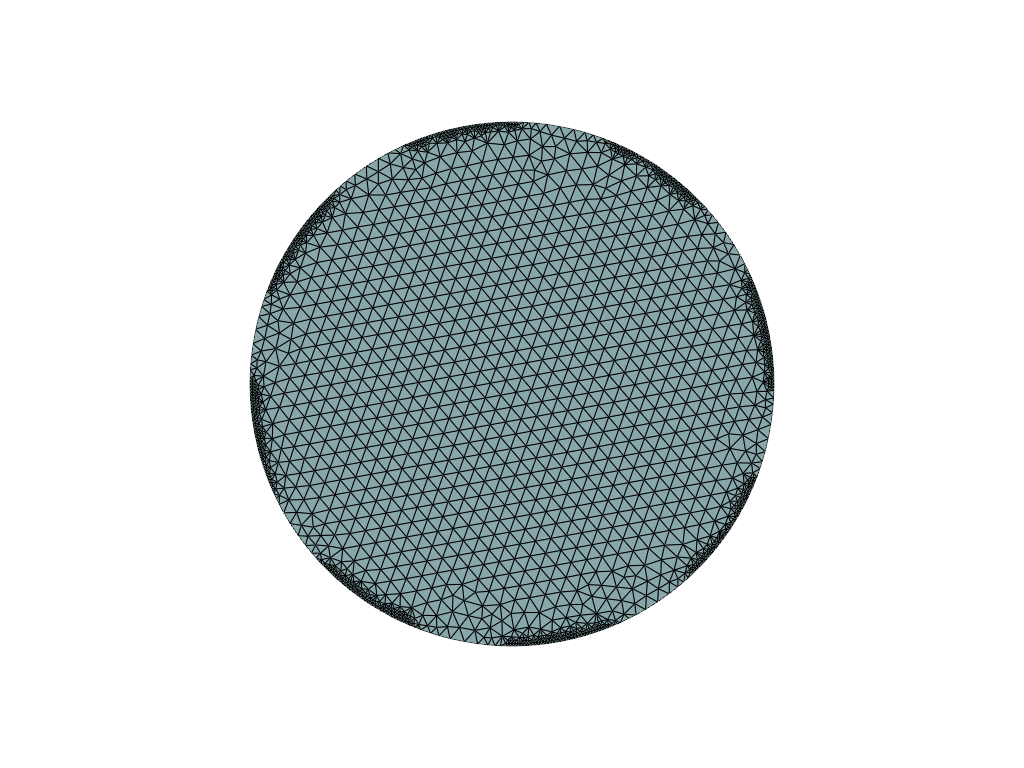

In [ ]:
plot_mesh(mesh)

# Setting mesh

## Finding Eletrodes

In [ ]:
# trecho do código do Eduardo
class electrodes_position():
    """
    Object that contains the position of the electrodes in the boundary.
    The position is stored as the initial and final angles of each electrode.

    :param L: Number of electrodes.
    :type L: int
    :param per_cober: Percentual covered length in the boundary by electrodes, between 0 and 1.
    :type per_cober: float
    :param rotate: Rotation angle in the original solution for electrodes (in radians).
    :type rotate: float
    :param anticlockwise: If True, the electrodes are positioned anticlockwise, else clockwise.
    :type anticlockwise: bool, optional (default is True)

    :Example:
        >>> ele_pos = electrodes_position(L=16, per_cober=0.5, rotate=0)
        >>> print(ele_pos.position)
        [[0.0, 0.19634954084936207],
         [0.39269908169872414, 0.5890486225480862],
         [0.7853981633974483, 0.9817477042468103],
         [1.1780972450961724, 1.3744467859455345],
         [1.5707963267948966, 1.7671458676442586],
         ...,
         [5.890486225480862, 6.086835766330224]]
    """

    def __init__(self, L, per_cober, rotate, anticlockwise=True):
        #Checks
        if not isinstance(L, int): raise ValueError("Number of electrodes must be an integer.")
        if not isinstance(per_cober, float): raise ValueError("per_cober must be a float.")
        if not isinstance(rotate, (int, float)): raise ValueError("rotate must be a float.")
        if not isinstance(anticlockwise, bool): raise ValueError("anticlockwise must be true of false.")
        if per_cober>1: raise ValueError("per_cober must be equal or less than 1. Example (75%): per_cober=0.75 ")

        self.rotate=rotate
        self.L=L
        self.per_cober=per_cober
        self.anticlockwise=anticlockwise

        self.position=self.calc_position()


    def calc_position(self):
        """
        Calculate the position of electrodes based on the :class:`electrodes_position` object.

        :returns: list of arrays -- Returns a list with angle initial and final of each electrode.
        """
        size_e=2*np.pi/self.L*self.per_cober       #Size electrodes
        size_gap=2*np.pi/self.L*(1-self.per_cober) #Size gaps
        rotate=self.rotate                      #Rotating original solution

        electrodes=[]
        for i in range(self.L):
            #Example electrodes=[[0, pi/4], [pi/2, pi]]
            electrodes.append([size_e*i+size_gap*i+rotate, size_e*(i+1)+size_gap*i+rotate]) #Grouping angular values for electrodes.
        if not self.anticlockwise:
            electrodes[1:] = electrodes[1:][::-1] #Keep first electrode and reverse order
        return electrodes
L=16
perc=0.5

electrodes = electrodes_position(L,perc,0)
# print(electrodes.position)
#vetor com as coordenadas iniciais e finais de cada eletrodo
elec_coordinates = [((np.cos(electrode[0]),np.sin(electrode[0])), (np.cos(electrode[1]),np.sin(electrode[1]))) for electrode in electrodes.position]

In [ ]:
mesh_refining = 0.4 #scaling factor for all domain refinement
bdr_refining = 0.6 # scaling factor for border refining

# if running again, you must remove the comment in the following
gmsh.finalize()
gmsh.initialize()
disk = gmsh.model.occ.addDisk(0, 0, 0, 1, 1) #creates disk centered in (0,0,0) with axis (1,1)

#create point list for electrodes.
#primeiro, do jeito gambiarrento -
electrodes_points = []
for electrode in electrodes.position:
  theta_array = np.linspace(electrode[0],electrode[1],)
  electrodes_points.extend([gmsh.model.occ.addPoint(np.cos(theta),np.sin(theta),0) for theta in theta_array])

gmsh.model.occ.synchronize()
gdim = 2 #variable to control disk dimension, where 2 stands for surface
gmsh.model.addPhysicalGroup(gdim, [disk], 1) # starts mesh object
# gmsh.model.addPhysicalGroup(0, electrodes_points, 2) #electrodes


gmsh.option.setNumber("Mesh.CharacteristicLengthMax",0.2 * mesh_refining) # control max length of cells
gmsh.model.mesh.field.add("Distance", 1)
gmsh.model.mesh.field.setNumbers(1, "PointsList", electrodes_points)
gmsh.model.mesh.field.add("Threshold", 2)
gmsh.model.mesh.field.setNumber(2, "InField", 1)
gmsh.model.mesh.field.setNumber(2, "SizeMin", 0.03 * bdr_refining)
gmsh.model.mesh.field.setNumber(2, "SizeMax", 0.25 * bdr_refining )
gmsh.model.mesh.field.setNumber(2, "DistMin", 0.075 * bdr_refining )
gmsh.model.mesh.field.setNumber(2, "DistMax", 0.1 * bdr_refining)
gmsh.model.mesh.field.add("Min", 3)
gmsh.model.mesh.field.setNumbers(3, "FieldsList", [2])
gmsh.model.mesh.field.setAsBackgroundMesh(3)
gmsh.option.setNumber("Mesh.MeshSizeExtendFromBoundary", 0)
gmsh.option.setNumber("Mesh.MeshSizeFromPoints", 0)
gmsh.option.setNumber("Mesh.MeshSizeFromCurvature", 0)
gmsh.model.mesh.generate(gdim)

#start graphic server
pyvista.start_xvfb()
gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD

#convert gmsh created mesh to dolfin/fenics mesh objects
mesh, cell_markers, facet_markers = gmshio.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=gdim)
topology, cell_types, x = dolfinx.plot.vtk_mesh(mesh) #convert dolfin mesh to vtk (plotting lib) manageable object

## Plotting domain

static


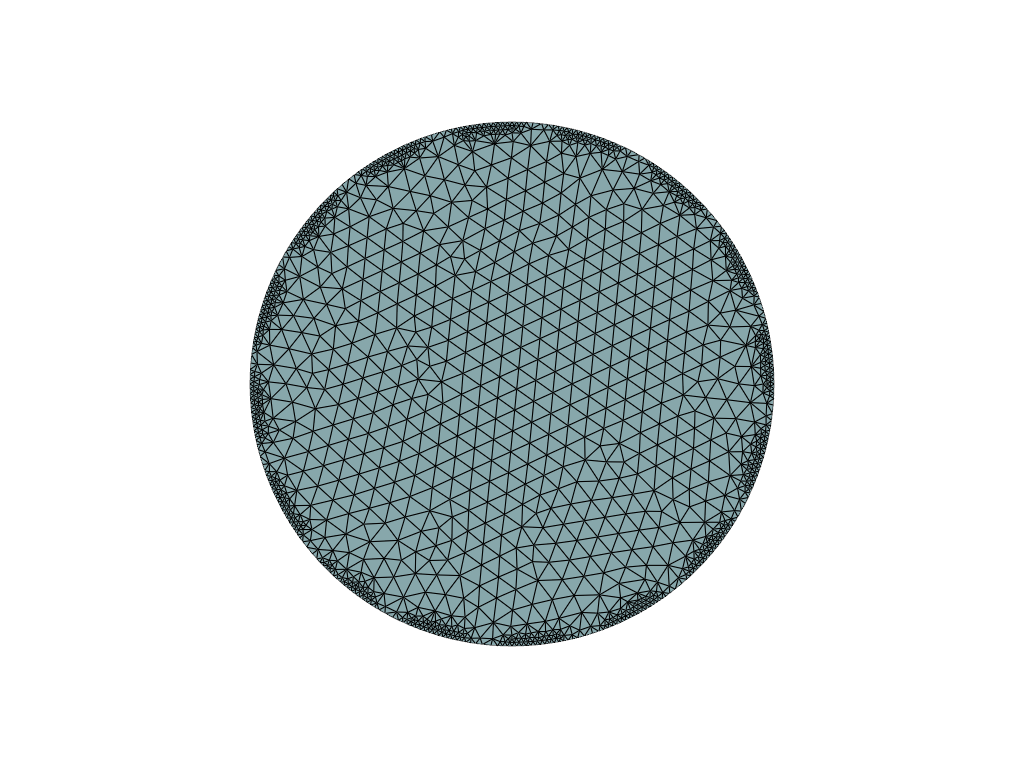

In [ ]:
#set value (plotting zero function in mesh)
num_cells_local = mesh.topology.index_map(mesh.topology.dim).size_local #get vertex array size
marker = np.zeros(num_cells_local, dtype=np.int32) #zero-full array, represents value in each vertex

# plotter object settings
# option "static" for static plots. Interactive options were not working properly in colab
pyvista.set_jupyter_backend("static")
print(pyvista.global_theme.jupyter_backend)

# Ploting mesh
p = pyvista.Plotter(notebook=True)
grid = pyvista.UnstructuredGrid(topology, cell_types, x)
p.add_mesh(grid, show_edges=True)
p.view_xy()
if pyvista.OFF_SCREEN:
    figure = p.screenshot("disk.png")
p.show()

## Getting integration domains

Based on the method explored in:
https://jsdokken.com/dolfinx-tutorial/chapter3/robin_neumann_dirichlet.html

Basic idea:
- Create a indicator function for each domain, the electrodes in our case;
- Uses fenicsx `dolfinx.mesh.locate_entities(mesh, fdim, locator)` for listing the tags which lies in the electrodes;
- Creates a custom `ds` integration object, informing the electrodes tags. Then, it is possible to compute the integration in the $i-th$ domain by the command `f * ds(i)`.

In our code, the electrodes are located by their starting and ending angles, here stored in `electrodes.position` array. Then, we use the indicator function $f_k$ for the $k-th$ electrode. Beeing $\theta$ the boundary point angle, and given $\theta^{(k)}_i,\theta^{(k)}_f$ the starting and ending electrode angles respectively, $f_k(\theta)$ may be get by:
$$
f_k(\theta) = \begin{cases}
1, \text{if } \theta_i^{(k)} \leq \theta \leq \theta_f^{(k)} \\
0, else.
\end{cases}
$$

Here, as fenicsx inform an array of cartesian coordinates, we may get the corresponding $\theta$ by the function?
$$
\theta(x,y) = \begin{cases}
  \arccos(x), \text{ if } y\geq 0\\
  2\pi - \arccos(x), \text{ else}.
\end{cases}
$$
given $(x,y) = (r\cos(\theta),r\sin(\theta))$ with $\theta \in [0,2\pi )$.

In [ ]:
# gets theta of (x,y) in polar coord. (r,theta), with theta in interval [0,2pi]
def theta(x):
  r = (x[0]**2 + x[1]**2)**(0.5)
  inv_r = np.where(np.isclose(r,0),0,1/r)
  return np.where(x[1]>=0,np.arccos(x[0]*inv_r),2*np.pi - np.arccos(x[0]*inv_r))

# Here is a tolerance for the test theta_i-tol <= theta <= theta_f
# this shown some better results on the integrations
tol = 0.01 # tolerance for checking if in electordes

#setting boundaries markers and indicator functions
boundaries = [
    (i, lambda x,i=i: np.where(np.logical_and(theta(x)>=electrodes.position[i][0]-tol,theta(x)<=electrodes.position[i][1]+tol),1,0))
    # (i, lambda x,i=i: np.where(theta(x)>=electrodes.position[i][0],1,0))
    for i in range(L)
]

#creating facet tags
facet_indices, facet_markers = [], []
fdim = mesh.topology.dim - 1
for (marker, locator) in boundaries:
    facets = dolfinx.mesh.locate_entities(mesh, fdim, locator)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets, marker))
facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
facet_tag = dolfinx.mesh.meshtags(mesh, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

In [ ]:
# Create the `ds` object for integration domains
ds = ufl.Measure("ds", domain=mesh, subdomain_data=facet_tag)

### Testing domains

Testing integral over electrodes. Here, we compute
$$
\int_{e_i} 1 ds
$$
for each $e_i \subset \partial \Omega$ electrode, through the fenicsx functions
```
v = ufl.TrialFunction(V0)
s = v*ds(i)
```

Given the circular domain, with all electrodes having same side and covering a $0<p<1$ fraction of the boundary, we expect that

$$
\int_{e_i} 1 ds = \frac{2 \pi}{L}*p
$$

In [ ]:
#Computing "true" area
electrode_real_area = 2*np.pi/L * perc
print("Electrode area: ",electrode_real_area)

Electrode area:  0.19634954084936207


In [ ]:
V0 = dolfinx.fem.FunctionSpace(mesh, ("DG", 0)) #Function space object

cell_area_list = []
for i in range(L):
  v = ufl.TrialFunction(V0) #trial object
  s = v*ds(i) # creates object of the form \int_{e_i} 1*ds

  cell_area_form = dolfinx.fem.form(s)
  cell_area = dolfinx.fem.assemble_scalar(cell_area_form)
  cell_area_list.append(cell_area.real)
  print("Electrode ", i ,": ", cell_area)

print("Sum:", sum(cell_area_list))

Electrode  0 :  (0.19170726283534886+0j)
Electrode  1 :  (0.19170726283534886+0j)
Electrode  2 :  (0.19170726283534897+0j)
Electrode  3 :  (0.1917072628353492+0j)
Electrode  4 :  (0.1917072628353487+0j)
Electrode  5 :  (0.1917072628353492+0j)
Electrode  6 :  (0.19170726283534917+0j)
Electrode  7 :  (0.19170726283534917+0j)
Electrode  8 :  (0.1917072628353483+0j)
Electrode  9 :  (0.1917072628353474+0j)
Electrode  10 :  (0.19170726283534878+0j)
Electrode  11 :  (0.1917072628353478+0j)
Electrode  12 :  (0.19170726283534875+0j)
Electrode  13 :  (0.19170726283534695+0j)
Electrode  14 :  (0.1917072628353469+0j)
Electrode  15 :  (0.1917072628353479+0j)
Sum: 3.0673162053655743


In [ ]:
cell_area_array = np.array(cell_area_list)
error_array = cell_area_array-electrode_real_area
print("Electrode length:", electrode_real_area)
electrode_area_df = pd.DataFrame({"Calculated area": cell_area_array,"Error": error_array})
electrode_area_df.head(n=L)

Electrode length: 0.19634954084936207


Calculated area     Error
0          0.191707 -0.004642
1          0.191707 -0.004642
2          0.191707 -0.004642
3          0.191707 -0.004642
4          0.191707 -0.004642
5          0.191707 -0.004642
6          0.191707 -0.004642
7          0.191707 -0.004642
8          0.191707 -0.004642
9          0.191707 -0.004642
10         0.191707 -0.004642
11         0.191707 -0.004642
12         0.191707 -0.004642
13         0.191707 -0.004642
14         0.191707 -0.004642
15         0.191707 -0.004642

Here, ploting the indicator function in all domain. Note that we get not only on boundary, but interior, for where we get this "radial" plot.

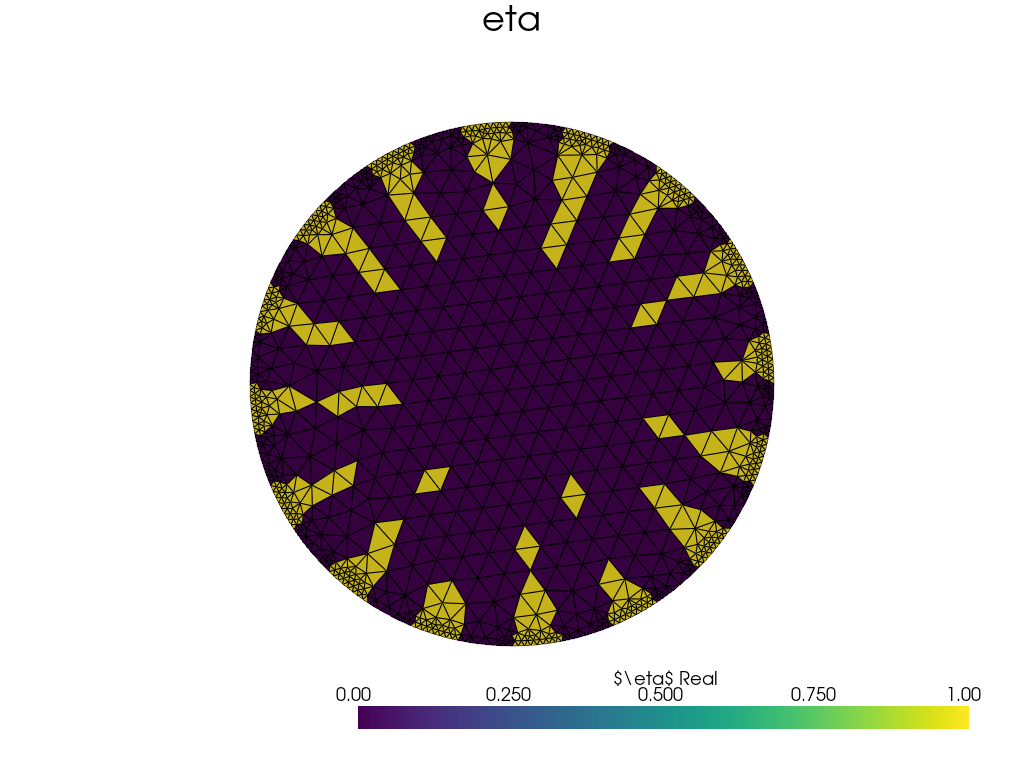

In [ ]:
V0 = dolfinx.fem.FunctionSpace(mesh, ("DG", 0)) #space of piecewise constant functions in omega

eta = dolfinx.fem.Function(V0, dtype=np.complex128) #create a null function in the space

for i in range(L):
  eta_cells = dolfinx.mesh.locate_entities(mesh,2,boundaries[i][1]) #cells that respect the indicator
  eta.x.array[eta_cells] = 1  #define the vertex with set index as 1, rest remain as 0

#Plotting eta
p_mesh = pyvista.UnstructuredGrid(*dolfinx.plot.vtk_mesh(mesh,mesh.topology.dim))
pyvista_cells, cell_types, geometry = dolfinx.plot.vtk_mesh(mesh)

grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)

grid.cell_data["$\eta$ Real"] = eta.x.array.real
grid.cell_data["$\eta$ Imaginary"] = eta.x.array.imag

grid.set_active_scalars("$\eta$ Real")
p_real = pyvista.Plotter(notebook=True)
p_real.add_text("eta", position="upper_edge", font_size=14, color="black")
p_real.add_mesh(grid,show_edges=True)
p_real.view_xy()
# p_real.set_background("white")
if not pyvista.OFF_SCREEN:
    p_real.show(jupyter_backend="static")



Testing with functions of different values on $E_i$. I.e., computing
$$
\int_{E_i} i dx
$$

In [ ]:
V0 = dolfinx.fem.FunctionSpace(mesh, ("DG", 0)) #Function space object

integral_list = []
for i in range(L):
  cte = dolfinx.fem.Constant(mesh, PETSc.ScalarType(i+1))
  v = ufl.TrialFunction(V0) #trial object
  s = cte * v * ds(i) # creates object of the form \int_{e_i} 1*ds

  integral_form = dolfinx.fem.form(s)
  integral = dolfinx.fem.assemble_scalar(integral_form)
  integral_list.append(integral.real)
  print("Electrode ", i ,": ", integral)


Electrode  0 :  (0.19170726283534886+0j)
Electrode  1 :  (0.3834145256706977+0j)
Electrode  2 :  (0.5751217885060469+0j)
Electrode  3 :  (0.7668290513413968+0j)
Electrode  4 :  (0.9585363141767436+0j)
Electrode  5 :  (1.1502435770120953+0j)
Electrode  6 :  (1.3419508398474442+0j)
Electrode  7 :  (1.5336581026827933+0j)
Electrode  8 :  (1.7253653655181345+0j)
Electrode  9 :  (1.9170726283534738+0j)
Electrode  10 :  (2.1087798911888362+0j)
Electrode  11 :  (2.3004871540241743+0j)
Electrode  12 :  (2.4921944168595336+0j)
Electrode  13 :  (2.6839016796948565+0j)
Electrode  14 :  (2.875608942530204+0j)
Electrode  15 :  (3.0673162053655663+0j)


In [ ]:
integral_array = np.array(integral_list)
error_array = integral_array - electrode_real_area*np.arange(1,L+1)
print("Electrode length:", electrode_real_area)
electrode_area_df = pd.DataFrame({"Calculated Integral": integral_array,"True Integral":electrode_real_area*np.arange(1,L+1),"Error": error_array})
electrode_area_df.head(n=L)

Electrode length: 0.19634954084936207


Calculated Integral  True Integral     Error
0              0.191707       0.196350 -0.004642
1              0.383415       0.392699 -0.009285
2              0.575122       0.589049 -0.013927
3              0.766829       0.785398 -0.018569
4              0.958536       0.981748 -0.023211
5              1.150244       1.178097 -0.027854
6              1.341951       1.374447 -0.032496
7              1.533658       1.570796 -0.037138
8              1.725365       1.767146 -0.041781
9              1.917073       1.963495 -0.046423
10             2.108780       2.159845 -0.051065
11             2.300487       2.356194 -0.055707
12             2.492194       2.552544 -0.060350
13             2.683902       2.748894 -0.064992
14             2.875609       2.945243 -0.069634
15             3.067316       3.141593 -0.074276

# Direct Problem

In Hafemann EIT code done in legacy fenics (https://github.com/HafemannE/FEIT_CBM34), he used mixed spaces (analogue for $H^1(\Omega)\oplus \mathbb R^L$) for constructing the problem. Occurs that in dolfinx this still doesn't have support. Some forum questions about mixed spaces in dolfinx:

https://jsdokken.com/dolfinx-tutorial/chapter3/robin_neumann_dirichlet.html

https://fenicsproject.discourse.group/t/mixed-function-space-with-dolfinx-how-to-implement-an-integral-constraint/9672

https://fenicsproject.discourse.group/t/singular-poisson-equation-in-dolfinx/12632/7

https://fenicsproject.discourse.group/t/how-can-i-use-block-forms-multiphenicsx-and-lagrange-multipliers-to-solve-poissons-equation-with-pure-neumann-boundary-conditions/12911

https://github.com/FEniCS/dolfinx/issues/1983


Stokes example (more on block matrix solvers): https://docs.fenicsproject.org/dolfinx/main/python/demos/demo_stokes.html


One alternative found is to assemble the matrix by parts, joining in an block vector. Based on following method: https://fenicsproject.discourse.group/t/is-it-possible-to-insert-a-vector-into-an-assembled-matrix/14118/6.

As described in Polydorides and Santana, the CEM discretized matrix is given by:
$$
A = \begin{bmatrix}
A^{(1)} & A^{(2)} \\
(A^{(2)})^T & A^{(4)}
\end{bmatrix}
$$
with
$$
A^{(1)}_{p,n} = \begin{bmatrix}
\left( \sum_{j=1}^{K} \gamma_j \int_{T_j} \nabla \Upsilon_p \cdot \nabla \Upsilon_n dx \right) + \left( \sum_{j=1}^{L} \frac{1}{z_j} \int_{E_j} \Upsilon_p \Upsilon_n dS \right)
\end{bmatrix} \in \mathbb{R}^{N \times N}
$$

$$
A^{(2)}_{p,n} = \begin{bmatrix}
 \left(- \frac{1}{z_n} \int_{E_n} \Upsilon_p dS \right)
\end{bmatrix}\in \mathbb{R}^{N \times L}
$$
$$
A^{(4)}_{p,k} = \begin{bmatrix}
 \left( \frac{1}{z_p} \int_{E_p} dS \right)
\end{bmatrix}\in \mathbb{R}^{L \times L}
$$

Obs:
- Only $A^{(1)}$ depends on $\gamma$. The rest may be precomputed, changing only $A^{(1)}$ in each step of inverse problem solver for different $\gamma$.

## Assembling matrices

In [106]:
V = dolfinx.fem.FunctionSpace(mesh, ("CG", 1)) #creates function space in mesh
V0 = dolfinx.fem.FunctionSpace(mesh, ("DG",0))

N = V.dofmap.index_map.size_global

z_value = 0.025

gamma = dolfinx.fem.Constant(mesh, PETSc.ScalarType(1))
z = dolfinx.fem.Constant(mesh, PETSc.ScalarType(z_value))
I = np.zeros(L)
I[0] = 1; I[1] = -1

In [107]:
u = ufl.TrialFunction(V) #function u_h
v = ufl.TestFunction(V)

gradu = ufl.grad(u)
gradv = ufl.grad(v)

#A1
A1_sum_array = [(1/z)*ufl.inner(u,v)*ds(i) for i in range(L)]
A1_form = (gamma * ufl.inner(gradu, gradv)) * ufl.dx + np.sum(A1_sum_array)
A1_form_obj = dolfinx.fem.form(A1_form)
A1_matrix = dolfinx.fem.petsc.assemble_matrix(A1_form_obj)

###

#A2
A2_form_array = [-ufl.inner((1/z), v) * ds(i) for i in range(L)]
A2_form_obj = [dolfinx.fem.form(form) for form in A2_form_array]
A2_vector_array= [dolfinx.fem.petsc.assemble_vector(form) for form in A2_form_obj]

A2_matrix = PETSc.Mat().create(comm=MPI.COMM_WORLD)
A2_matrix.setSizes([N,L])
for j in range(L):
  A2_matrix.setValues(range(N),j,A2_vector_array[j].getValues(range(N)))
A2_matrix.assemble()
# A2T_matrix = A2_matrix.transpose()
# A2T_matrix.assemble()

###

#A4
cell_area_list = []
for i in range(L):
  v = ufl.TrialFunction(V0) #trial object
  s = v*ds(i) # creates object of the form \int_{e_i} 1*ds
  cell_area_form = dolfinx.fem.form(s)
  cell_area = dolfinx.fem.assemble_scalar(cell_area_form)
  cell_area_list.append(cell_area.real)
cell_area_array = np.array(cell_area_list)
A4_diagonal = np.diag(cell_area_array*(1/z_value))

A4_matrix = PETSc.Mat().create(comm=MPI.COMM_WORLD)
A4_matrix.setSizes(L)
A4_matrix.setValues(range(L),range(L),A4_diagonal.ravel())
# A4_matrix.assemble()
# a4 = A4_matrix.getValues(range(L),range(L))


## Solving by numpy (single current)

Getting trouble while dealing with PETSc vectors. Little workaround below:
- converting PETSc matrices and vectors generated by fenics to numpy array objects;
- solving by least squares using numpy matrix structure;

This is slow and probably leads to huge error. Using only as alternative while solvig PETSc.

In [108]:
A1_matrix.assemble()
A1_np_matrix = A1_matrix.getValues(range(N),range(N))
A2_np_matrix = A2_matrix.getValues(range(N),range(L))

A_np = np.block([[A1_np_matrix, A2_np_matrix],
                [A2_np_matrix.T.conj(), A4_diagonal]])

b = np.block([np.zeros(N),I])

In [109]:
u_nest = np.linalg.lstsq(A_np,b)[0] #least square solution of Au=b
u_array, U_array = u_nest[:N], u_nest[N:] #splitting array

# translating solutions (U = (U1 + S/L,...,UL + S/L)), with S = U1+...+UL
S = U_array.sum()
U_array -= S/L
u_array -= S/L

U measured array: [ 0.70490976+0.j -0.70460678+0.j -0.18940652+0.j -0.08436913+0.j
 -0.02498045+0.j  0.02489463+0.j  0.08428139+0.j  0.18927708+0.j]
U sum:  (2.7755575615628914e-17+0j)


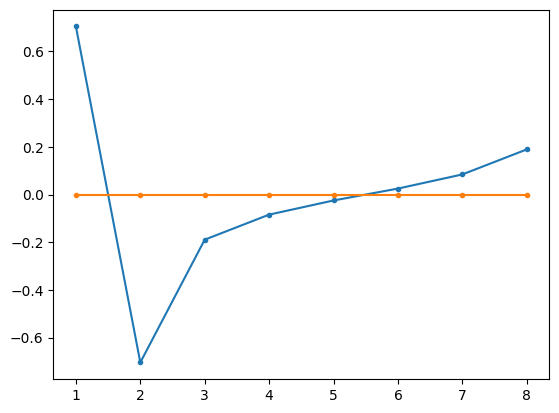

In [110]:
print("U measured array:",U_array)
print("U sum: ", U_array.sum())
plt.plot(np.arange(1,L+1),U_array.real, marker='.')
plt.plot(np.arange(1,L+1),U_array.imag, marker='.')
plt.show()

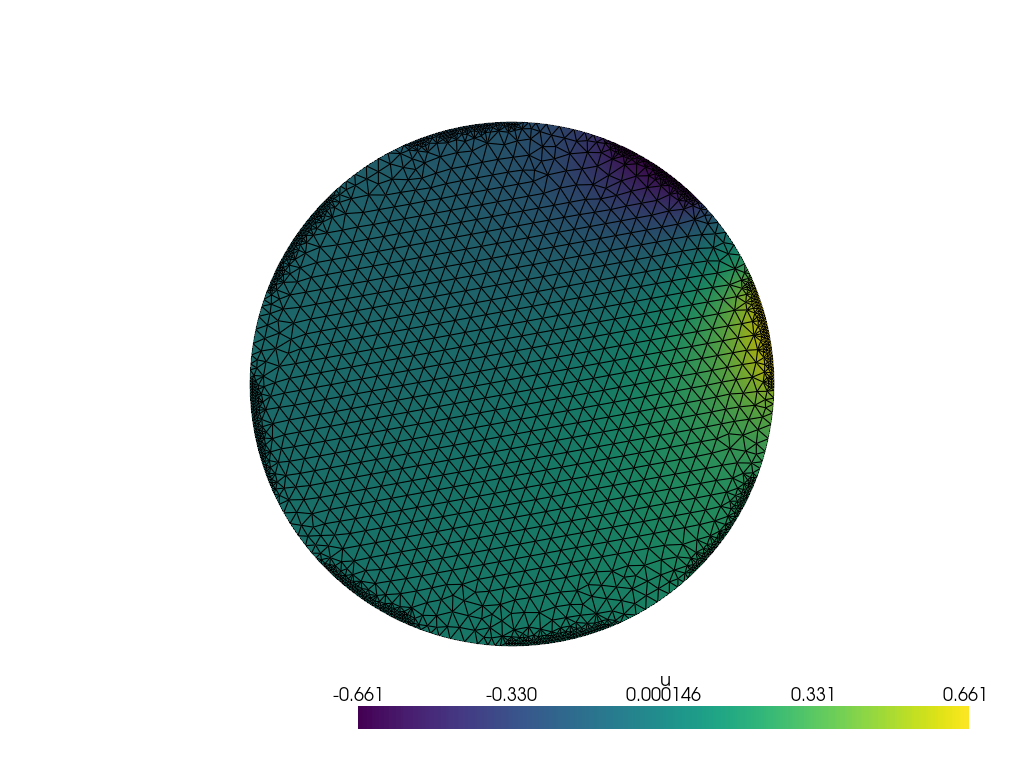

In [111]:
u_func = dolfinx.fem.Function(V)
u_func.x.array[:] = u_array.real

plot_tent_function(u_func)

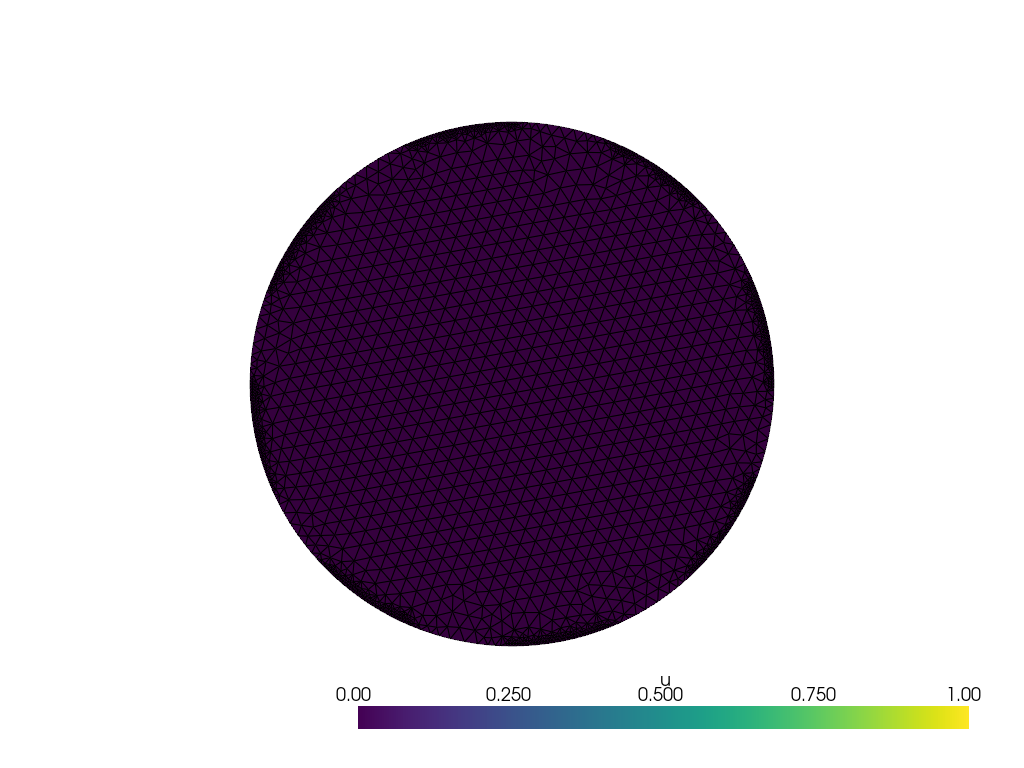

In [112]:
u_func = dolfinx.fem.Function(V)
u_func.x.array[:] = u_array.imag

plot_tent_function(u_func)

  return np.asarray(x, float)



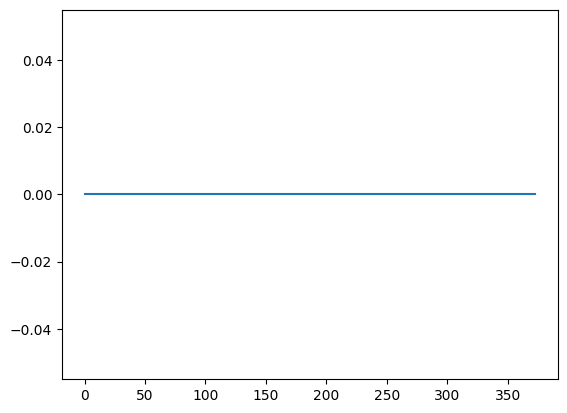

In [113]:
u_bdr_array = get_boundary_data(u_func)
plt.plot(u_bdr_array)

## Consistency tests

### Test 1: integral x current
$$
\int_{e_j} \gamma \frac{\partial u}{\partial \eta} dS = I_j
$$

In [114]:
int_array = []
n = ufl.FacetNormal(mesh)
for j in range(L):
  form = dolfinx.fem.form((gamma * ufl.inner(ufl.grad(u_func),n)) * ds(j))
  value = dolfinx.fem.assemble_scalar(form)
  int_array.append(value)

int_array = np.array(int_array)

int_df = pd.DataFrame({"Currents Array (I)":I, "Integral Array": int_array, "Error":I-int_array})
int_df.head(n=L)
# print("Currents array: ",I)
# print("Integral array:", int_array)
# print("Error:", I-int_array)

  return umr_sum(a, axis, dtype, out, keepdims, initial, where)



Currents Array (I)  Integral Array     Error
0                 1.0        0.0+0.0j  1.0+0.0j
1                -1.0        0.0+0.0j -1.0+0.0j
2                 0.0        0.0+0.0j  0.0+0.0j
3                 0.0        0.0+0.0j  0.0+0.0j
4                 0.0        0.0+0.0j  0.0+0.0j
5                 0.0        0.0+0.0j  0.0+0.0j
6                 0.0        0.0+0.0j  0.0+0.0j
7                 0.0        0.0+0.0j  0.0+0.0j

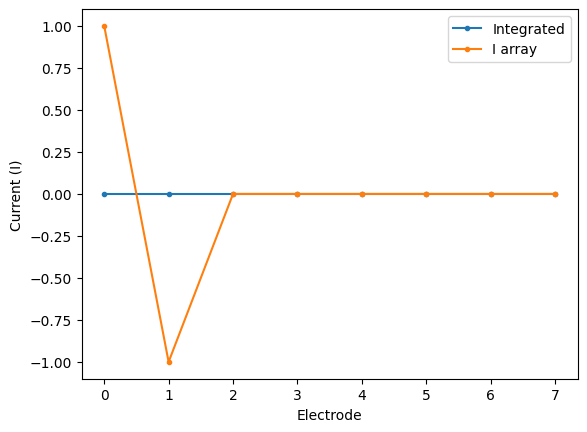

In [115]:

plt.plot(int_array.real, label="Integrated",marker='.')
plt.plot(I, label="I array",marker='.')
plt.legend()
plt.ylabel("Current (I)")
plt.xlabel("Electrode")
plt.show()

### Test 2: flux in gaps

Verifying plot of $\gamma \nabla u \cdot \eta$ on boundary

Couldn't use the fenics projections, computing it using analytic geometry stuff.

Getting index of triangles with facet on boundary

Idea from https://fenicsproject.discourse.group/t/define-a-boundary-from-dg-elements/5723/2

In [116]:
# The code below gets all triangles with a facet (edge) contained in boundary.
mesh.topology.create_connectivity(1, mesh.topology.dim)
facet_to_cell = mesh.topology.connectivity(1, mesh.topology.dim)
def boundary_locator(x):
    return np.isclose(x[0]**2+x[1]**2, 1)

boundary_facets = dolfinx.mesh.locate_entities(mesh, 1, boundary_locator)
boundary_cells = []
for facet in boundary_facets:
    boundary_cells.append(facet_to_cell.links(facet))
boundary_cells = np.hstack(boundary_cells)

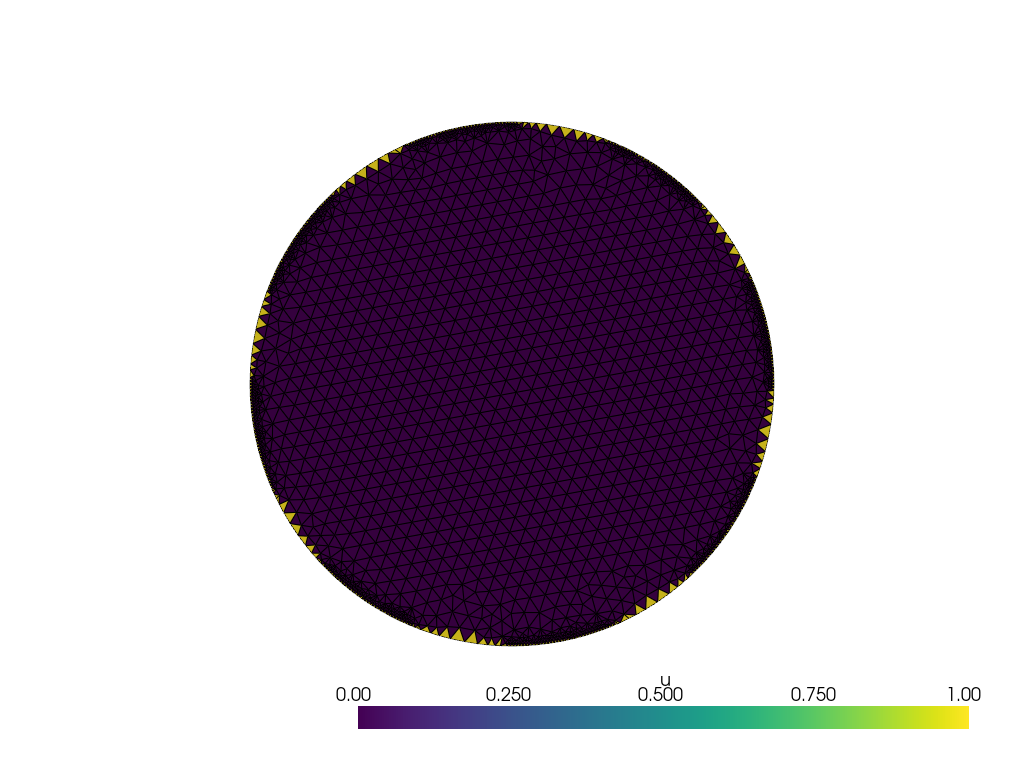

In [117]:
# indicator function on the selected cells
test_func = dolfinx.fem.Function(V0)
test_func.x.array[boundary_cells] = 1
plot_indicator_function(test_func)

In [118]:
adjacency_list = mesh.topology.connectivity(2,0)
mesh_vertex_index_list = []
for i in range(len(adjacency_list)):
  mesh_vertex_index_list.append(adjacency_list.links(i))

cells_coordinates_list = []
for cell_vertex_index in mesh_vertex_index_list:
  cells_coordinates_list.append(mesh.geometry.x[cell_vertex_index][:,:2])

#Compute grad(u_func)
# gradu_list = []
flux_list = []
for idx in mesh_vertex_index_list:
  cell_coord = mesh.geometry.x[idx][:,:2]
  system_array = np.concatenate((cell_coord,np.ones(3).reshape(3,1)),axis=1)
  u_t = u_func.x.array[idx]
  plane_coef = np.linalg.solve(system_array, u_t)
  gradu = plane_coef[:2]
  # gradu_x, gradu_y = plane_coef[0],plane_coef[1]

  #checks outer segment, compute normal vector pointing outward the domain
  idx_interior_point = np.argmin(np.linalg.norm(cell_coord,axis=1)) #idx of vertex on interior (closer to 0)
  interior_point = cell_coord[idx_interior_point]
  bdr_point_A, bdr_point_B = np.delete(cell_coord,[idx_interior_point],axis=0)
  AB = bdr_point_B - bdr_point_A
  AI = interior_point - bdr_point_A
  t = np.vdot(AB,AI)/np.vdot(AB,AB)
  projAB = bdr_point_A + t*AB
  Normal = projAB - interior_point
  normal = Normal/np.linalg.norm(Normal)

  # gamma_x = gamma.x.array[idx]
  gamma_x = 1

  flux_list.append(gamma_x * (np.vdot(normal,gradu)))

flux_array = np.array(flux_list)

In [119]:
#get angle of cell in each
dofs_coordinates = V0.tabulate_dof_coordinates()
x_bdr = dofs_coordinates[boundary_cells][:,0]
y_bdr = dofs_coordinates[boundary_cells][:,1]
theta = np.where(y_bdr>=0,np.arccos(x_bdr),2*np.pi - np.arccos(x_bdr))

In [120]:
#checks if angle in some electrode
electrode_marker = []
for angle in theta:
  inElectrode = False
  for (theta_i,theta_f) in electrodes.position:
    if theta_i<=angle and angle<=theta_f:
      inElectrode = True
      break
  electrode_marker.append(inElectrode)

electrode_marker = np.array(electrode_marker)

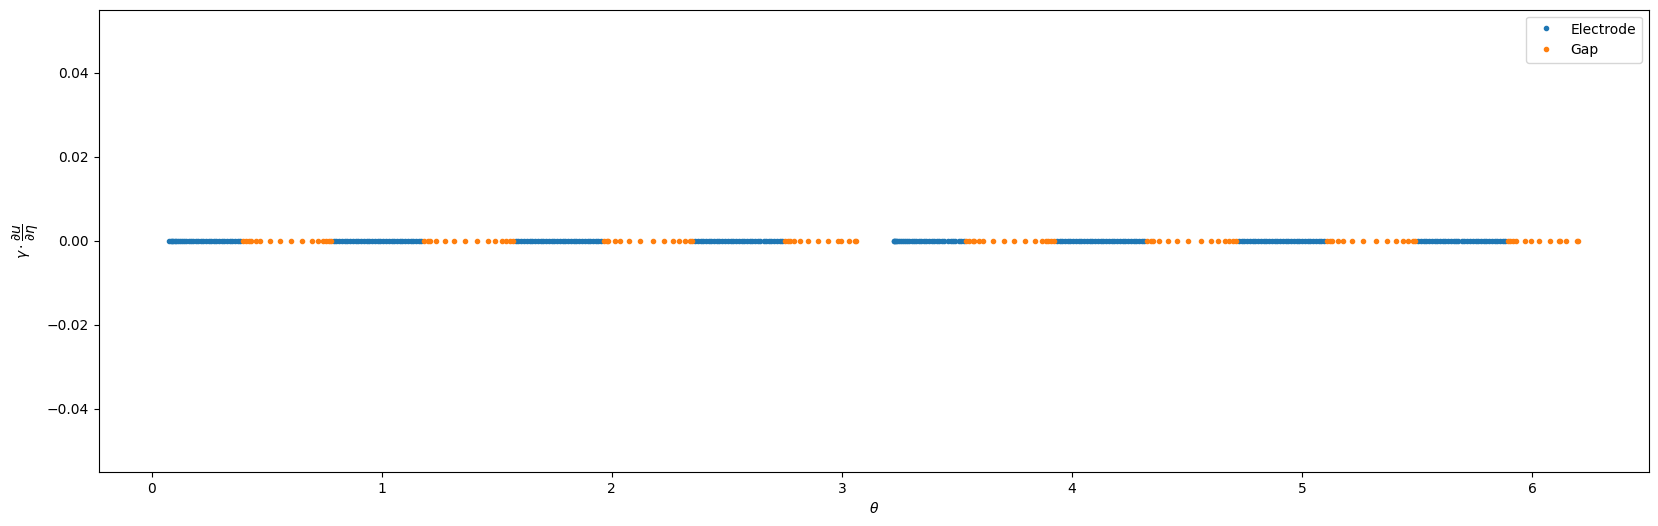

In [121]:
theta_cells_in_electrode = theta[electrode_marker]
theta_cells_out_electrode = theta[~electrode_marker]
flux_in_electrode = flux_array[boundary_cells][electrode_marker]
flux_out_electrode = flux_array[boundary_cells][~electrode_marker]


plt.figure(figsize=(20,6))
plt.plot(theta_cells_in_electrode,flux_in_electrode.real,marker='.',linestyle='',label="Electrode")
plt.plot(theta_cells_out_electrode,flux_out_electrode.real,marker='.',linestyle='',label='Gap')
plt.xlabel("$\\theta$")
plt.ylabel("$\gamma \cdot \dfrac{\partial u}{\partial \eta}$")
plt.legend()
plt.show()

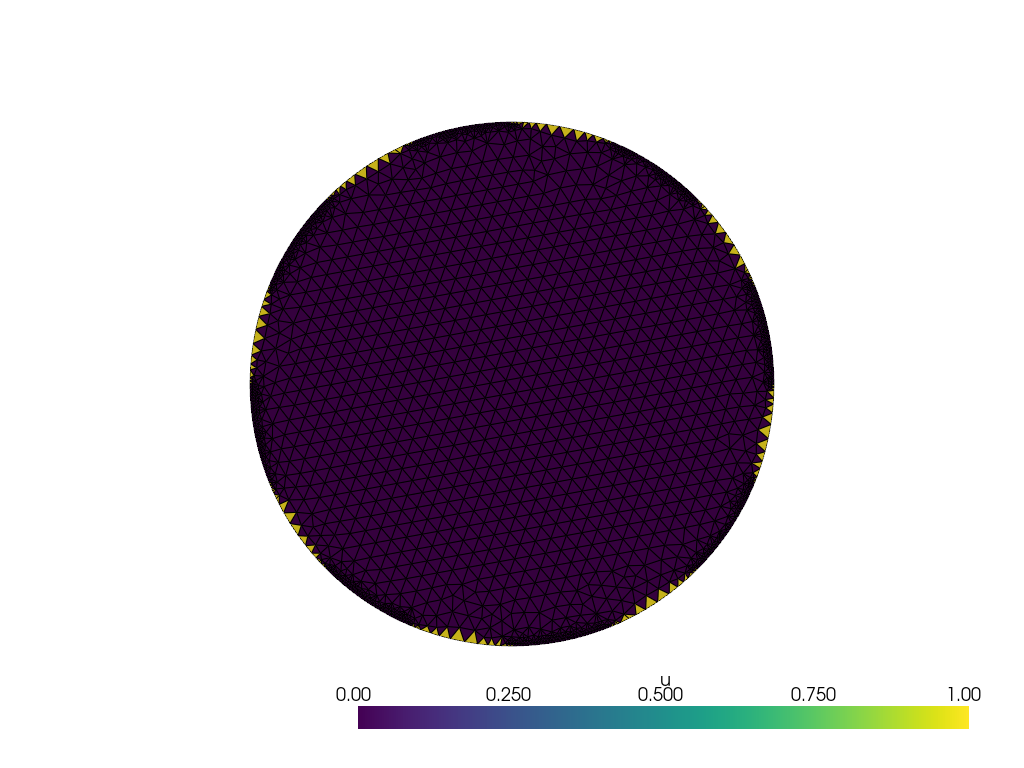

In [122]:
# indicator function on the selected cells
test_func = dolfinx.fem.Function(V0)
test_func.x.array[boundary_cells] = ~electrode_marker
plot_indicator_function(test_func)


### Test 3: potential in electrodes

Testing if
$$
U_j = u|_{e_j} + z_j \gamma \frac{\partial u}{\partial \eta}
$$


As $u$ is defined on the vertices and $\gamma \frac{\partial u}{\partial \eta}$ is constant in each edge, needs to chose which vertex and adjacent facet to evaluate.

Getting the following:
- order vertices and facets by angle;
- chose $u_j$ and $\gamma_j$ in the order set above.



In [123]:
#create connection
mesh.topology.create_connectivity(mesh.topology.dim-1, mesh.topology.dim)
boundary_facets = dolfinx.mesh.exterior_facet_indices(mesh.topology)
boundary_dofs_index_array = dolfinx.fem.locate_dofs_topological(V, mesh.topology.dim-1, boundary_facets) #array with the vertices index

#gets x and y coordinates for the boundary
V_dofs_coordinates = V.tabulate_dof_coordinates()
x_bdr = V_dofs_coordinates[boundary_dofs_index_array][:,0]
y_bdr = V_dofs_coordinates[boundary_dofs_index_array][:,1]
theta = np.where(y_bdr>=0,np.arccos(x_bdr),2*np.pi - np.arccos(x_bdr))
sorted_theta_vtx_index = np.argsort(theta)

#get angle of cell in each
V0_dofs_coordinates = V0.tabulate_dof_coordinates()
x_bdr = V0_dofs_coordinates[boundary_cells][:,0]
y_bdr = V0_dofs_coordinates[boundary_cells][:,1]
theta_cells = np.where(y_bdr>=0,np.arccos(x_bdr),2*np.pi - np.arccos(x_bdr))
sorted_theta_cll_index = np.argsort(theta_cells)


  return np.asarray(x, float)



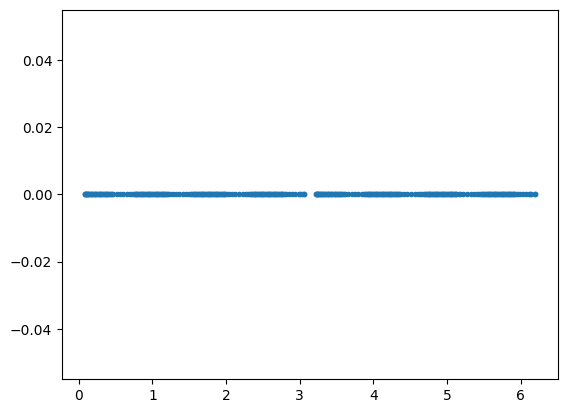

In [124]:
plt.plot(theta_cells[sorted_theta_cll_index],flux_array[sorted_bdr_cll_idx],linestyle='',marker='.')
plt.show()

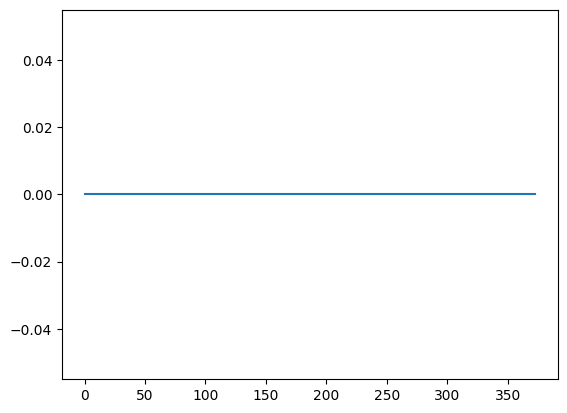

In [125]:
plt.plot(u_func.x.array[sorted_bdr_vtx_idx])
plt.show()

In [126]:
sorted_bdr_vtx_idx = boundary_dofs_index_array[sorted_theta_vtx_index]
sorted_bdr_cll_idx = boundary_cells[sorted_theta_cll_index]
U_star = u_func.x.array[sorted_bdr_vtx_idx] + z_value*flux_array[sorted_bdr_cll_idx]

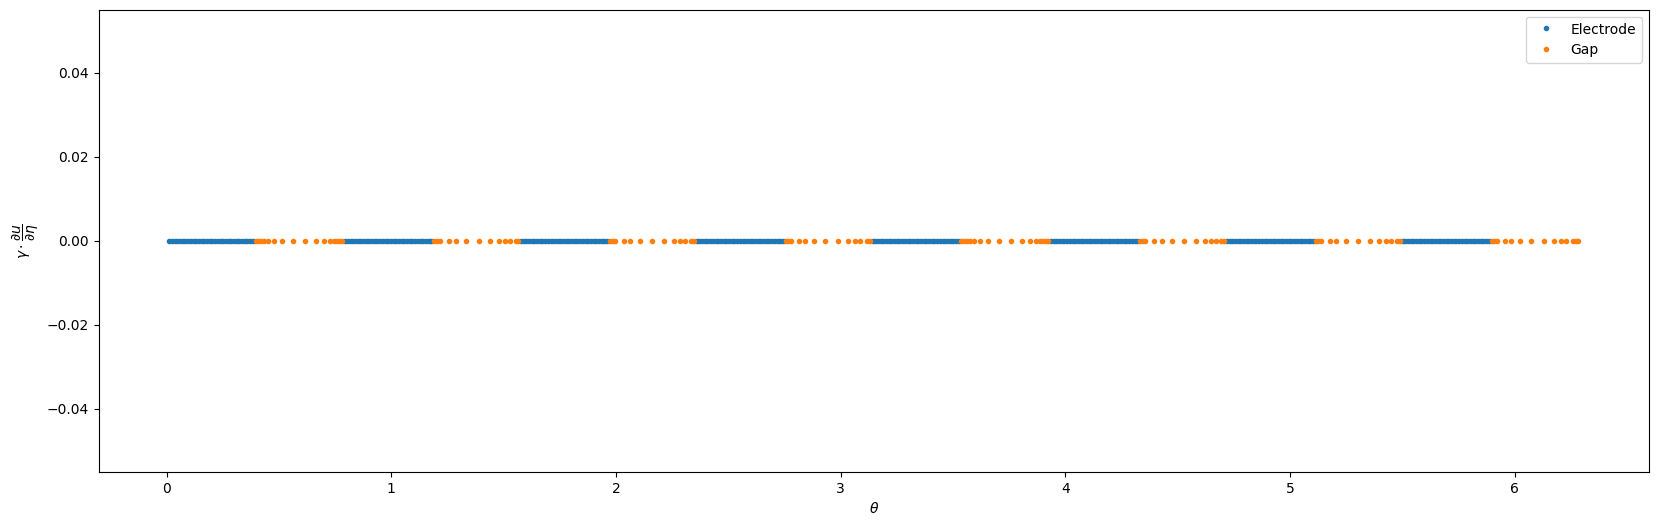

In [127]:
theta=np.sort(theta)

electrode_marker = []
for angle in theta:
  inElectrode = False
  for (theta_i,theta_f) in electrodes.position:
    if theta_i<=angle and angle<=theta_f:
      inElectrode = True
      break
  electrode_marker.append(inElectrode)
electrode_marker = np.array(electrode_marker)

theta_in_electrode = theta[electrode_marker]
theta_out_electrode = theta[~electrode_marker]
Ustar_in_electrode = U_star[electrode_marker]
Ustar_out_electrode = U_star[~electrode_marker]


plt.figure(figsize=(20,6))
plt.plot(theta_in_electrode,Ustar_in_electrode.real,marker='.',linestyle='',label="Electrode")
plt.plot(theta_out_electrode,Ustar_out_electrode.real,marker='.',linestyle='',label='Gap')
plt.xlabel("$\\theta$")
plt.ylabel("$\gamma \cdot \dfrac{\partial u}{\partial \eta}$")
plt.legend()
plt.show()

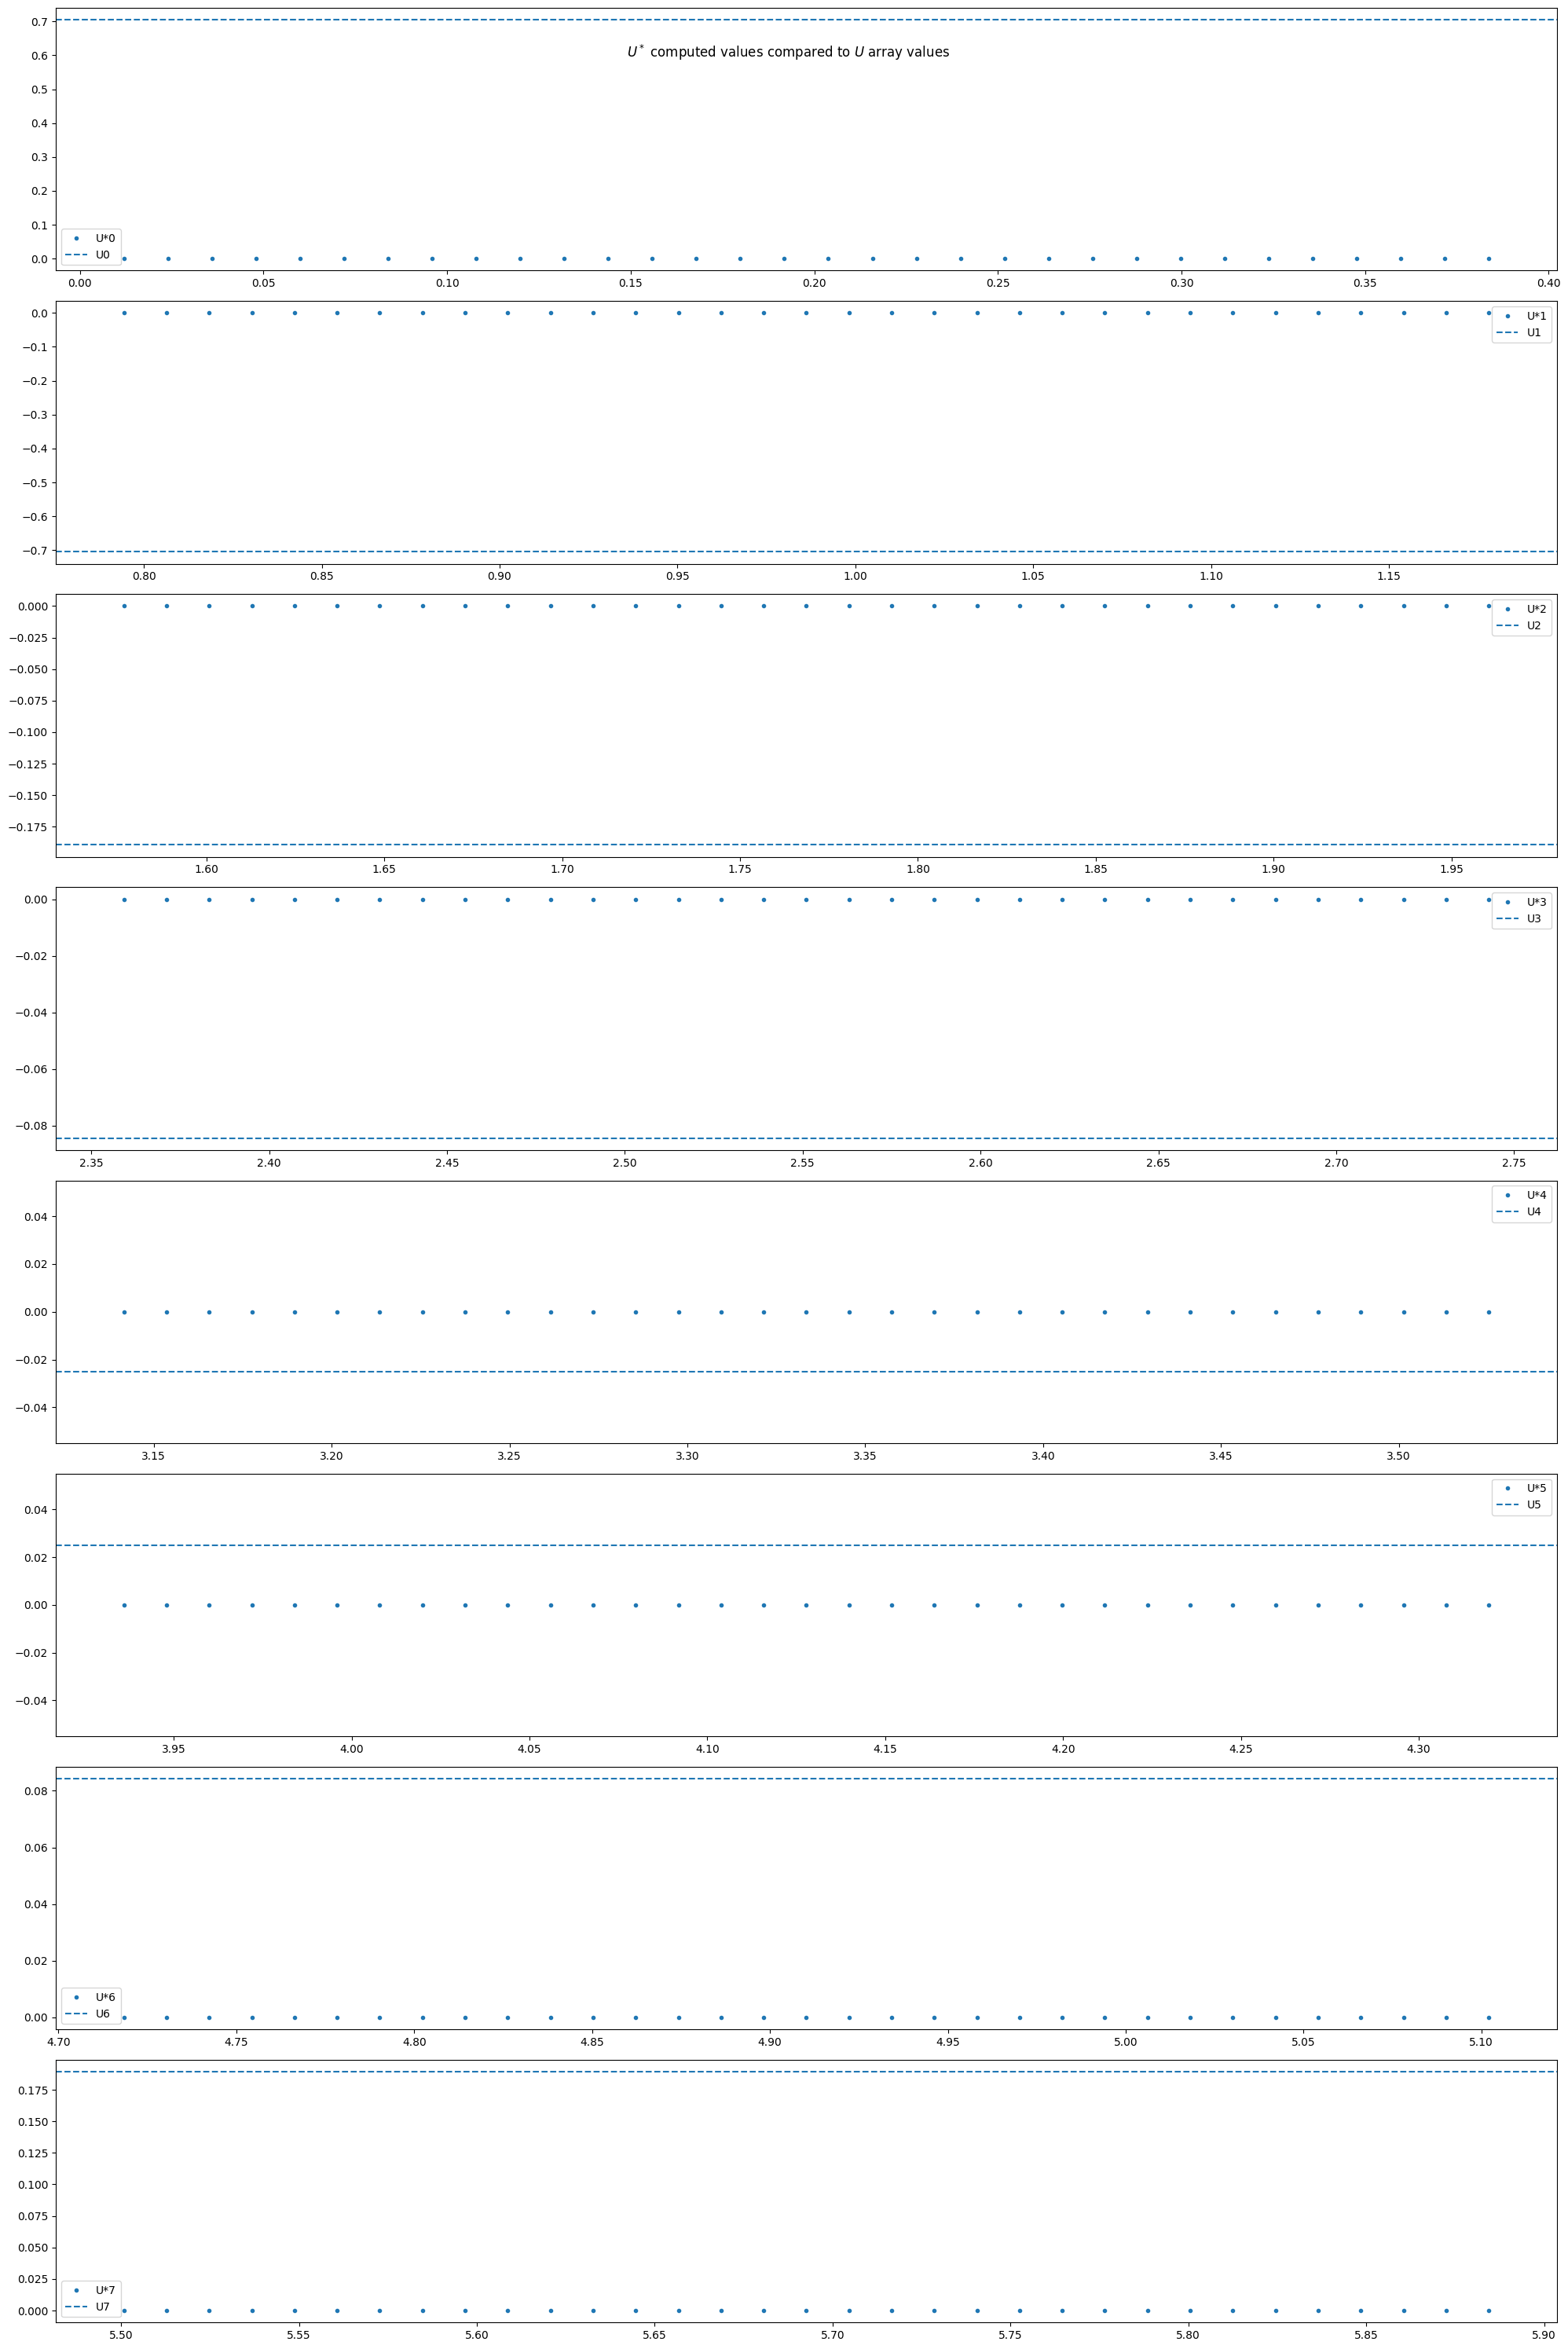

In [128]:
t = theta
fig,axs = plt.subplots(L,1,figsize=(20,30))

for j in range(L):
  theta_i,theta_f = electrodes.position[j]
  theta_j_idx = np.logical_and(t>=theta_i,t<=theta_f)#index of theta in electrode j
  axs[j].plot(t[theta_j_idx],U_star.real[theta_j_idx],label=f"U*{j}",linestyle='',marker='.')
  axs[j].axhline(U_array[j].real,label=f'U{j}',linestyle='--')
  axs[j].legend()
  # axs[j].set_xticks(np.linspace(0,2*np.pi,5),["0","$\\frac{\pi}{2}$","$\pi$","$\\frac{3\pi}{2}$","$2\pi$"])

  # axs[1].plot(t,f(t),label="exact")
  # axs[1].plot(t,u_bdr_imag_array,label="calculated")
  # axs[1].set_title("imaginary part")
  # axs[1].set_xticks(np.linspace(0,2*np.pi,5),["0","$\\frac{\pi}{2}$","$\pi$","$\\frac{3\pi}{2}$","$2\pi$"])
fig.tight_layout()
fig.suptitle("$U^*$ computed values compared to $U$ array values")
plt.show()

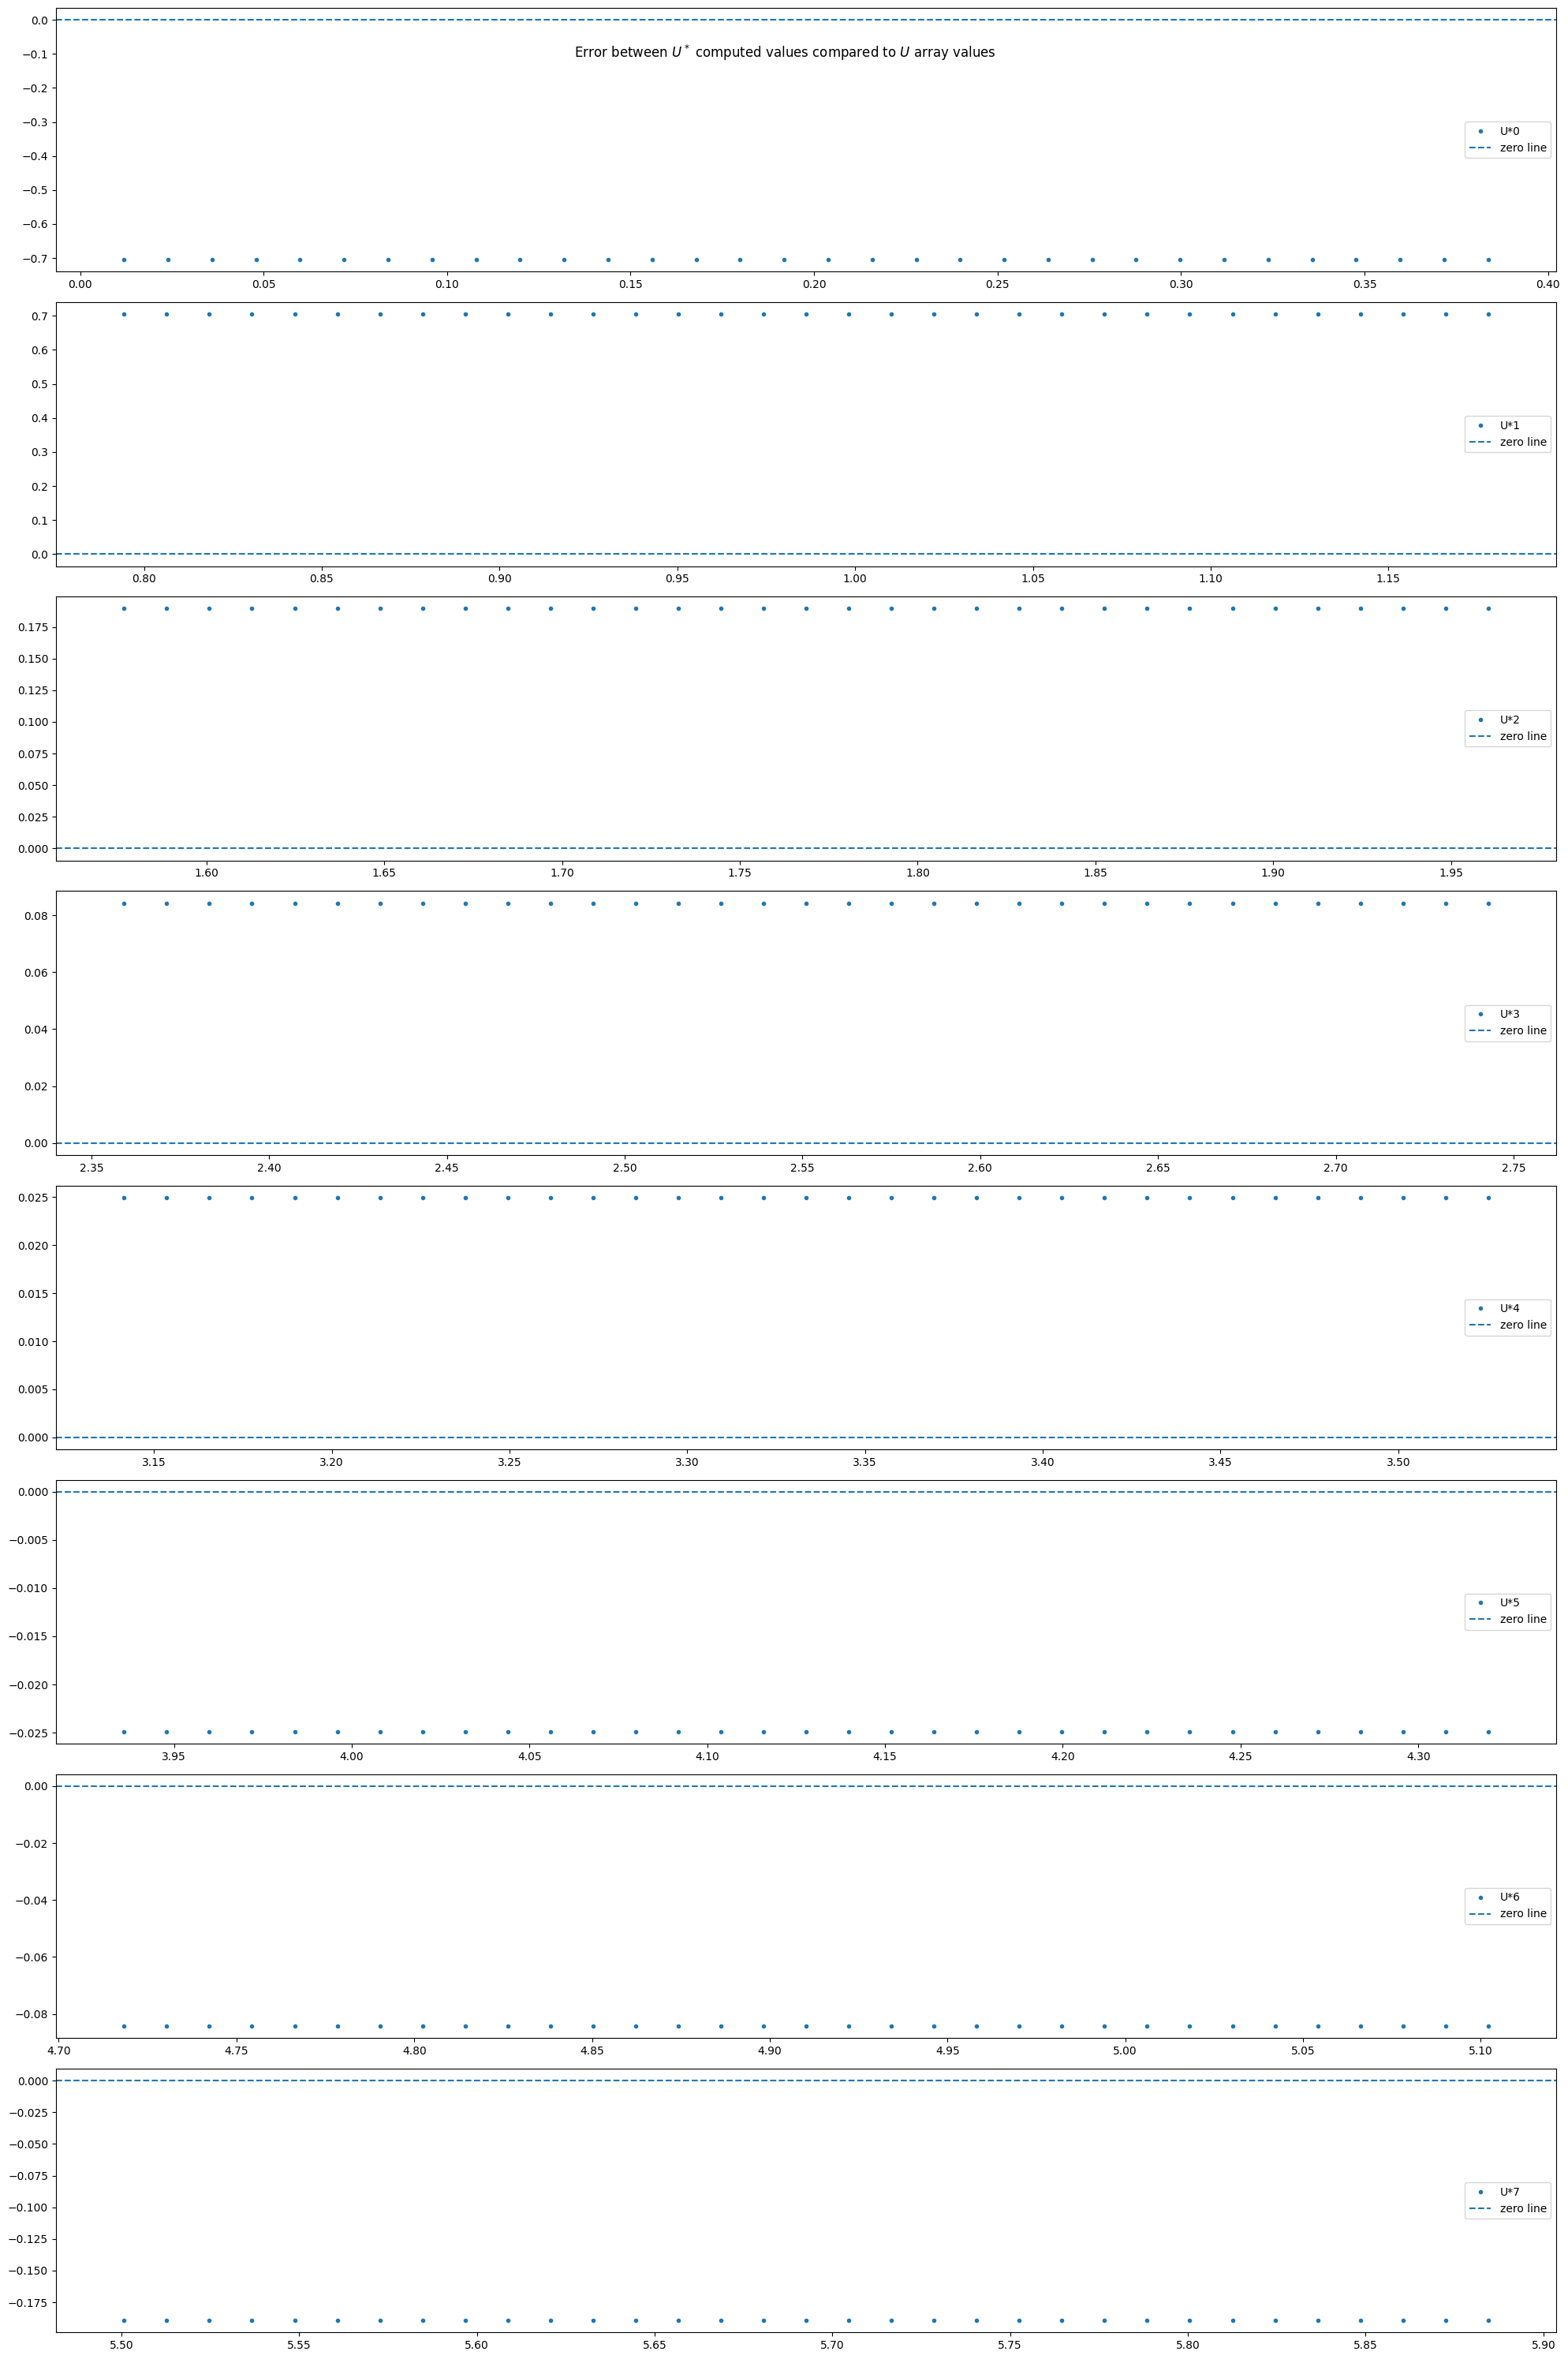

In [129]:
#eror
t = theta
fig,axs = plt.subplots(L,1,figsize=(20,30))

for j in range(L):
  theta_i,theta_f = electrodes.position[j]
  theta_j_idx = np.logical_and(t>=theta_i,t<=theta_f)#index of theta in electrode j
  axs[j].plot(t[theta_j_idx],U_star.real[theta_j_idx]-U_array[j].real,label=f"U*{j}",linestyle='',marker='.')
  axs[j].axhline(0,label=f'zero line',linestyle='--')
  axs[j].legend()
  # axs[j].set_xticks(np.linspace(0,2*np.pi,5),["0","$\\frac{\pi}{2}$","$\pi$","$\\frac{3\pi}{2}$","$2\pi$"])

  # axs[1].plot(t,f(t),label="exact")
  # axs[1].plot(t,u_bdr_imag_array,label="calculated")
  # axs[1].set_title("imaginary part")
  # axs[1].set_xticks(np.linspace(0,2*np.pi,5),["0","$\\frac{\pi}{2}$","$\pi$","$\\frac{3\pi}{2}$","$2\pi$"])
fig.tight_layout()
fig.suptitle("Error between $U^*$ computed values compared to $U$ array values")
plt.show()

## Solving by numpy (multiple currents)

In [13]:
A1_matrix.assemble()
A1_np_matrix = A1_matrix.getValues(range(N),range(N))
A2_np_matrix = A2_matrix.getValues(range(N),range(L))

A_np = np.block([[A1_np_matrix, A2_np_matrix],
                [A2_np_matrix.T, A4_diagonal]])


### Performance Comparison

Solving for multiple currents $I$:
- by getting $A^\dagger$ pseudoinverse through `np.linalg.pinv` method;
- by solving by least squares with `np.linalg.lstsq` for each vector;
- by solving the normal equation $A^*A\hat u = A^*\hat b$ each time

In [14]:
I_all = []
l=4
value = 1

for i in range(l):
  if i!=L-1:
    I=np.zeros(L)
    I[i], I[i+1]=value, -value
    I_all.append(I)
  else:
    I=np.zeros(L)
    I[0], I[i]=-value, value
    I_all.append(I)

Computing pseudoinverse, apllying to each b vector

In [118]:
%%time
pinv_u_list = []
pinv_U_list = []

A_pinv = np.linalg.pinv(A_np)

for k in range(l):
  b = np.block([np.zeros(N),I_all[k]])
  u_nest = A_pinv@b #least square solution of Au=b
  u_array, U_array = u_nest[:N], u_nest[N:] #splitting array
  # translating solutions (U = (U1 + S/L,...,UL + S/L)), with S = U1+...+UL
  S = U_array.sum()
  U_array -= S/L
  u_array -= S/L
  pinv_u_list.append(u_array)
  pinv_U_list.append(U_array)

CPU times: user 42.4 s, sys: 4.35 s, total: 46.7 s
Wall time: 27.6 s


Solving each time using `np.linalg.lstsq` method

In [119]:
%%time
lstsq_u_list = []
lstsq_U_list = []

for k in range(l):
  b = np.block([np.zeros(N),I_all[k]])
  u_nest = np.linalg.lstsq(A_np,b)[0] #least square solution of Au=b
  u_array, U_array = u_nest[:N], u_nest[N:] #splitting array
  # translating solutions (U = (U1 + S/L,...,UL + S/L)), with S = U1+...+UL
  S = U_array.sum()
  U_array -= S/L
  u_array -= S/L

  lstsq_u_list.append(u_array)
  lstsq_U_list.append(U_array)

CPU times: user 1min 31s, sys: 7.51 s, total: 1min 38s
Wall time: 1min 3s


Solving each time the normal equation by `np.linalg.solve`

In [15]:
%%time
normaleq_u_list = []
normaleq_U_list = []

for k in range(l):
  b = np.block([np.zeros(N),I_all[k]])
  u_nest = np.linalg.solve(A_np.T.conj()@A_np,A_np.T.conj()@b) #least square solution of Au=b
  u_array, U_array = u_nest[:N], u_nest[N:] #splitting array
  # translating solutions (U = (U1 + S/L,...,UL + S/L)), with S = U1+...+UL
  S = U_array.sum()
  U_array -= S/L
  u_array -= S/L

  normaleq_u_list.append(u_array)
  normaleq_U_list.append(U_array)

CPU times: user 23.6 s, sys: 2.08 s, total: 25.7 s
Wall time: 17.1 s


In [121]:
pinv_lstsq_err = []
pinv_neq_err = []
lstsq_neq_err = []

for k in range(l):
  pinv_lstsq_err.append(np.linalg.norm(pinv_u_list[k] - lstsq_u_list[k]))
  pinv_neq_err.append(np.linalg.norm(pinv_u_list[k] - normaleq_u_list[k]))
  lstsq_neq_err.append(np.linalg.norm(normaleq_u_list[k] - lstsq_u_list[k]))

print("Error comparison of u solution arrays (2-norm error)")
err_df = pd.DataFrame({"Pseudoinverse x lstsq":pinv_lstsq_err, "Pseudoinverse x normal eq.":pinv_neq_err, "Normal eq x lstsq":lstsq_neq_err})
err_df.head(n=l)

Error comparison of u solution arrays (2-norm error)


Pseudoinverse x lstsq  Pseudoinverse x normal eq.  Normal eq x lstsq
0           2.591606e-13                1.279759e-10       1.279824e-10
1           3.648653e-13                6.167788e-10       6.168336e-10
2           5.581480e-13                2.654259e-10       2.655685e-10
3           4.990623e-13                2.130654e-10       2.126883e-10

In [122]:
pinv_lstsq_err = []
pinv_neq_err = []
lstsq_neq_err = []

for k in range(l):
  pinv_lstsq_err.append(np.linalg.norm(pinv_U_list[k] - lstsq_U_list[k]))
  pinv_neq_err.append(np.linalg.norm(pinv_U_list[k] - normaleq_U_list[k]))
  lstsq_neq_err.append(np.linalg.norm(normaleq_U_list[k] - lstsq_U_list[k]))

print("Error comparison of U solution arrays (2-norm error)")
err_df = pd.DataFrame({"Pseudoinverse x lstsq":pinv_lstsq_err, "Pseudoinverse x normal eq.":pinv_neq_err, "Normal eq x lstsq":lstsq_neq_err})
err_df.head(n=l)

Error comparison of U solution arrays (2-norm error)


Pseudoinverse x lstsq  Pseudoinverse x normal eq.  Normal eq x lstsq
0           1.867646e-14                9.289052e-12       9.289181e-12
1           2.545600e-14                4.388391e-11       4.388749e-11
2           3.763440e-14                1.894486e-11       1.895423e-11
3           3.387494e-14                1.539792e-11       1.537373e-11

#### Testing sparse

In [18]:
import scipy as sp
A_sp = sp.sparse.csr_matrix(A_np)

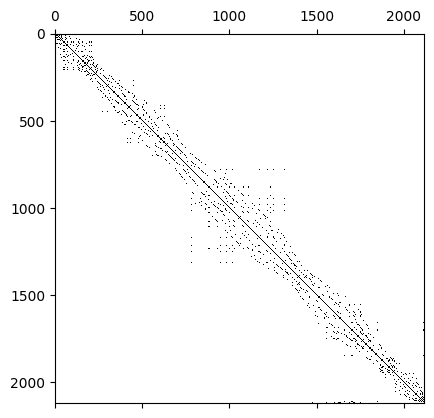

In [32]:
plt.spy(A_np.T.conj()@A_np,A_np.T.conj())

In [42]:
# A_sp = A^* A
A_sp = sp.sparse.csr_matrix(A_np.T.conj()@A_np)

In [43]:
%%time
sparse_normaleq_u_list = []
sparse_normaleq_U_list = []

for k in range(l):
  b = np.block([np.zeros(N),I_all[k]])
  u_nest = sp.sparse.linalg.spsolve(A_sp,A_np.T.conj()@b) #Solve A^*Au = b
  u_array, U_array = u_nest[:N], u_nest[N:] #splitting array
  # translating solutions (U = (U1 + S/L,...,UL + S/L)), with S = U1+...+UL
  S = U_array.sum()
  U_array -= S/L
  u_array -= S/L

  sparse_normaleq_u_list.append(u_array)
  sparse_normaleq_U_list.append(U_array)

CPU times: user 592 ms, sys: 702 ms, total: 1.29 s
Wall time: 685 ms


  return np.asarray(x, float)



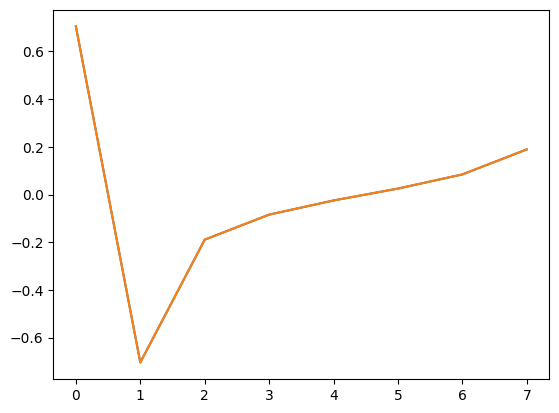

In [46]:
plt.plot(sparse_normaleq_U_list[0])
plt.plot(normaleq_U_list[0])
plt.show()

In [48]:
sparse_neq_err = []

for k in range(l):
  sparse_neq_err.append(np.linalg.norm(normaleq_u_list[k] - sparse_normaleq_u_list[k]))

print("Error comparison of u solution arrays (2-norm error)")
err_df = pd.DataFrame(sparse_neq_err)
err_df.head(n=l)

Error comparison of u solution arrays (2-norm error)


0
0  1.315172e-10
1  6.936311e-10
2  1.883463e-10
3  2.912161e-10

In [47]:
sparse_neq_err = []

for k in range(l):
  sparse_neq_err.append(np.linalg.norm(normaleq_U_list[k] - sparse_normaleq_U_list[k]))

print("Error comparison of U solution arrays (2-norm error)")
err_df = pd.DataFrame(sparse_neq_err)
err_df.head(n=l)

Error comparison of U solution arrays (2-norm error)


0
0  9.519947e-12
1  4.926502e-11
2  1.345687e-11
3  2.107591e-11

### Consistency tests

#### Solving direct problem

Currents:
$$
I_1 = [1 , -1 ,0\; \dots 0] \\
I_2 = [0,1,-1, \dots, 0]\\
\vdots
$$

In [50]:
A1_matrix.assemble()
A1_np_matrix = A1_matrix.getValues(range(N),range(N))
A2_np_matrix = A2_matrix.getValues(range(N),range(L))
A_np = np.block([[A1_np_matrix, A2_np_matrix],
                [A2_np_matrix.T, A4_diagonal]])

I_all = []
l=4
value = 1

for i in range(l):
  if i!=L-1:
    I=np.zeros(L)
    I[i], I[i+1]=value, -value
    I_all.append(I)
  else:
    I=np.zeros(L)
    I[0], I[i]=-value, value
    I_all.append(I)

u_array_list = []
u_func_list = []
U_array_list = []

# for k in range(l):

#   b = np.block([np.zeros(N),I_all[k]])
#   u_nest = np.linalg.solve(A_np.T.conj()@A_np,A_np.T.conj()@b) #least square solution of Au=b
#   u_array, U_array = u_nest[:N], u_nest[N:] #splitting array
#   # translating solutions (U = (U1 + S/L,...,UL + S/L)), with S = U1+...+UL
#   S = U_array.sum()
#   U_array -= S/L
#   u_array -= S/L

for k in range(l):
  b = np.block([np.zeros(N),I_all[k]])
  u_nest = sp.sparse.linalg.spsolve(A_sp,A_np.T.conj()@b) #Solve A^*Au = b
  u_array, U_array = u_nest[:N], u_nest[N:] #splitting array
  # translating solutions (U = (U1 + S/L,...,UL + S/L)), with S = U1+...+UL
  S = U_array.sum()
  U_array -= S/L
  u_array -= S/L

  u_func = dolfinx.fem.Function(V)
  u_func.x.array[:] = u_array

  u_array_list.append(u_array)
  u_func_list.append(u_func)
  U_array_list.append(U_array)



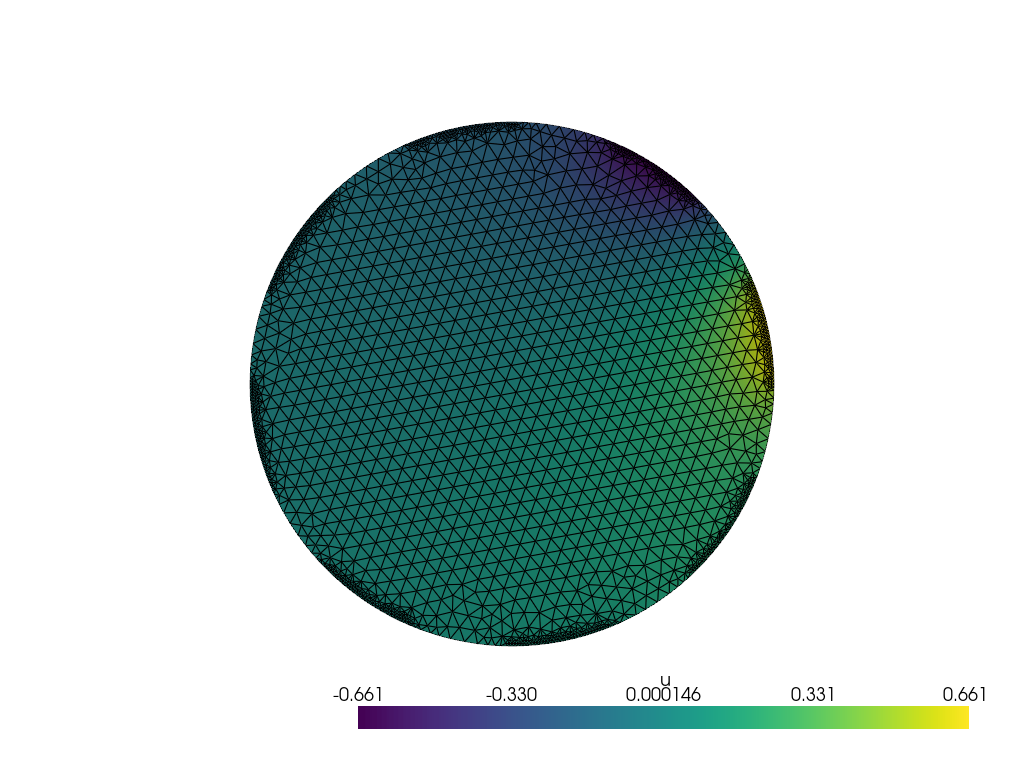

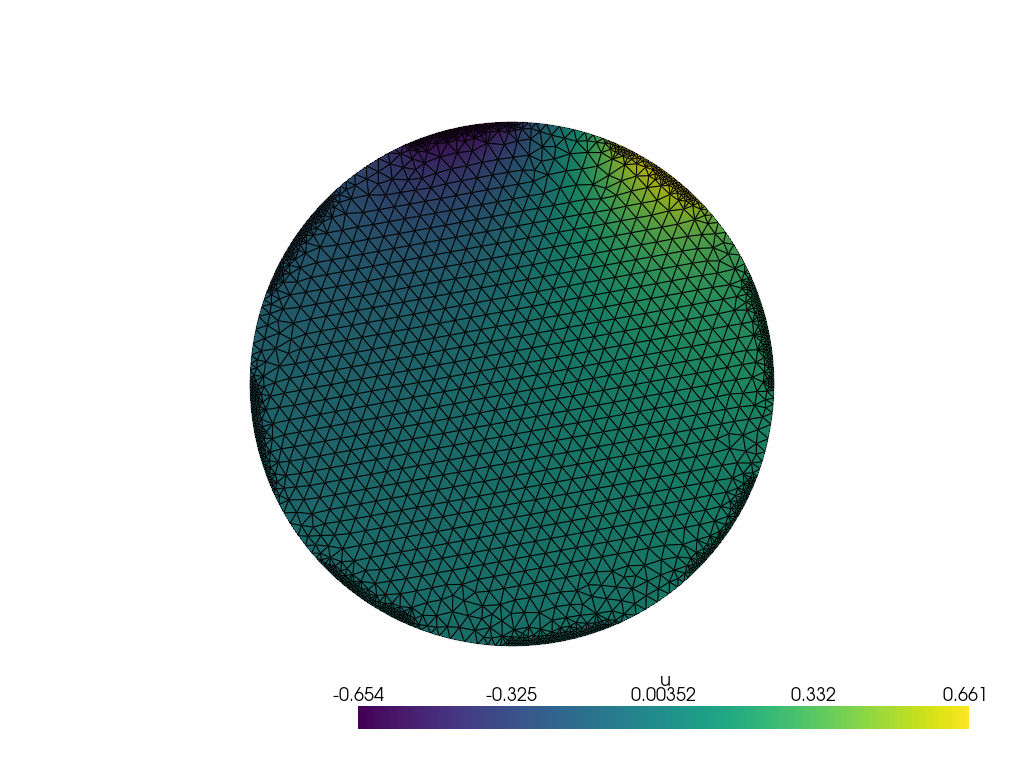

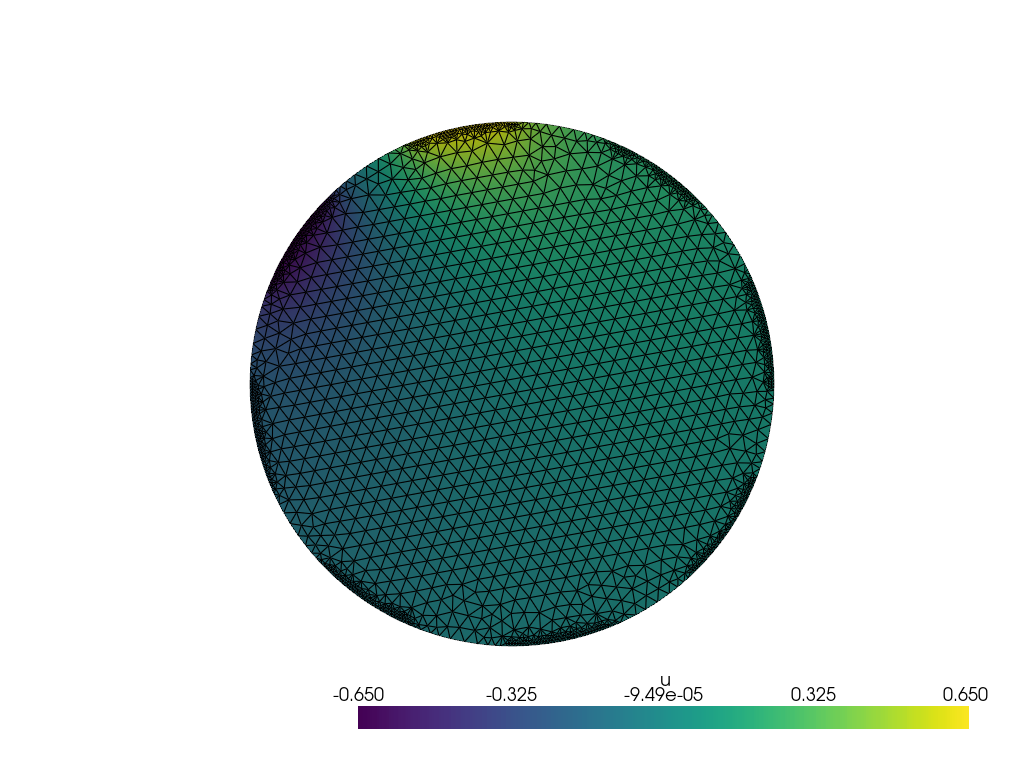

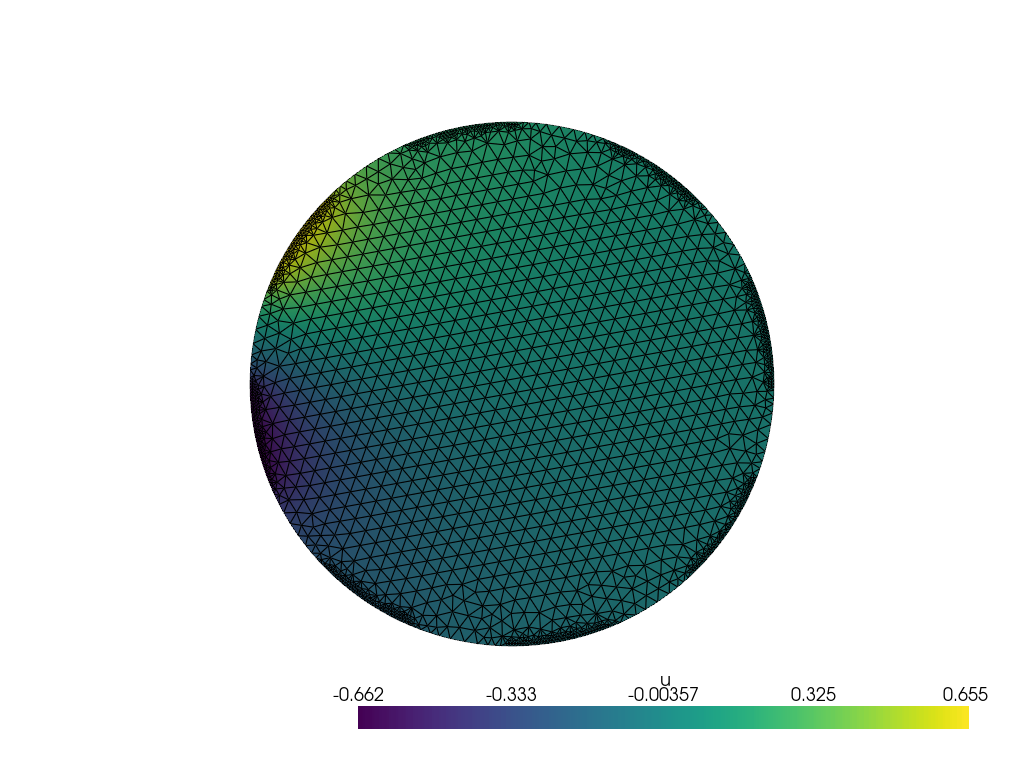

In [52]:
for k in range(l):
  plot_tent_function(u_func_list[k])

  return np.asarray(x, float)



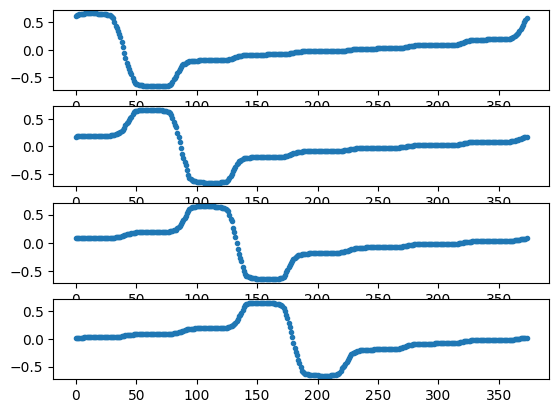

In [94]:
fig,ax = plt.subplots(l,1)

for k in range(l):
  uk_array = get_boundary_data(u_func_list[k])
  ax[k].plot(uk_array,linestyle='',marker='.')

plt.show()

#### Test 1: integral x current
$$
\int_{e_j} \gamma \frac{\partial u}{\partial \eta} dS = I_j
$$

In [53]:
int_array = []
I_all_array = np.array(I_all)

n = ufl.FacetNormal(mesh)
for k in range(l):
  int_k_list = [ ]
  for j in range(L):
    form = dolfinx.fem.form(ufl.inner(gamma, ufl.inner(ufl.grad(u_func_list[k]),n)) *ds(j))
    value = dolfinx.fem.assemble_scalar(form)
    int_k_list.append(value)

  int_array.append(int_k_list)

int_array = np.array(int_array)

for k in range(l):
  print("Current",k)
  int_df = pd.DataFrame({"Currents Array (I)":I_all_array[k], "Integral Array": int_array[k], "Error":I_all_array[k]-int_array[k]})
  print(int_df.head(n=L))
  # print("Currents array: ",I)
  # print("Integral array:", int_array)
  # print("Error:", I-int_array)

Current 0
   Currents Array (I)      Integral Array               Error
0                 1.0  0.916505+0.000000j  0.083495+0.000000j
1                -1.0 -0.919467+0.000000j -0.080533+0.000000j
2                 0.0 -0.002191+0.000000j  0.002191+0.000000j
3                 0.0 -0.000471+0.000000j  0.000471+0.000000j
4                 0.0  0.000088+0.000000j -0.000088+0.000000j
5                 0.0  0.000024+0.000000j -0.000024+0.000000j
6                 0.0  0.000607+0.000000j -0.000607+0.000000j
7                 0.0  0.002193+0.000000j -0.002193+0.000000j
Current 1
   Currents Array (I)      Integral Array               Error
0                 0.0  0.002014+0.000000j -0.002014+0.000000j
1                 1.0  0.920918+0.000000j  0.079082+0.000000j
2                -1.0 -0.920685+0.000000j -0.079315+0.000000j
3                 0.0 -0.002450+0.000000j  0.002450+0.000000j
4                 0.0 -0.000168+0.000000j  0.000168+0.000000j
5                 0.0 -0.000138+0.000000j  0.00013

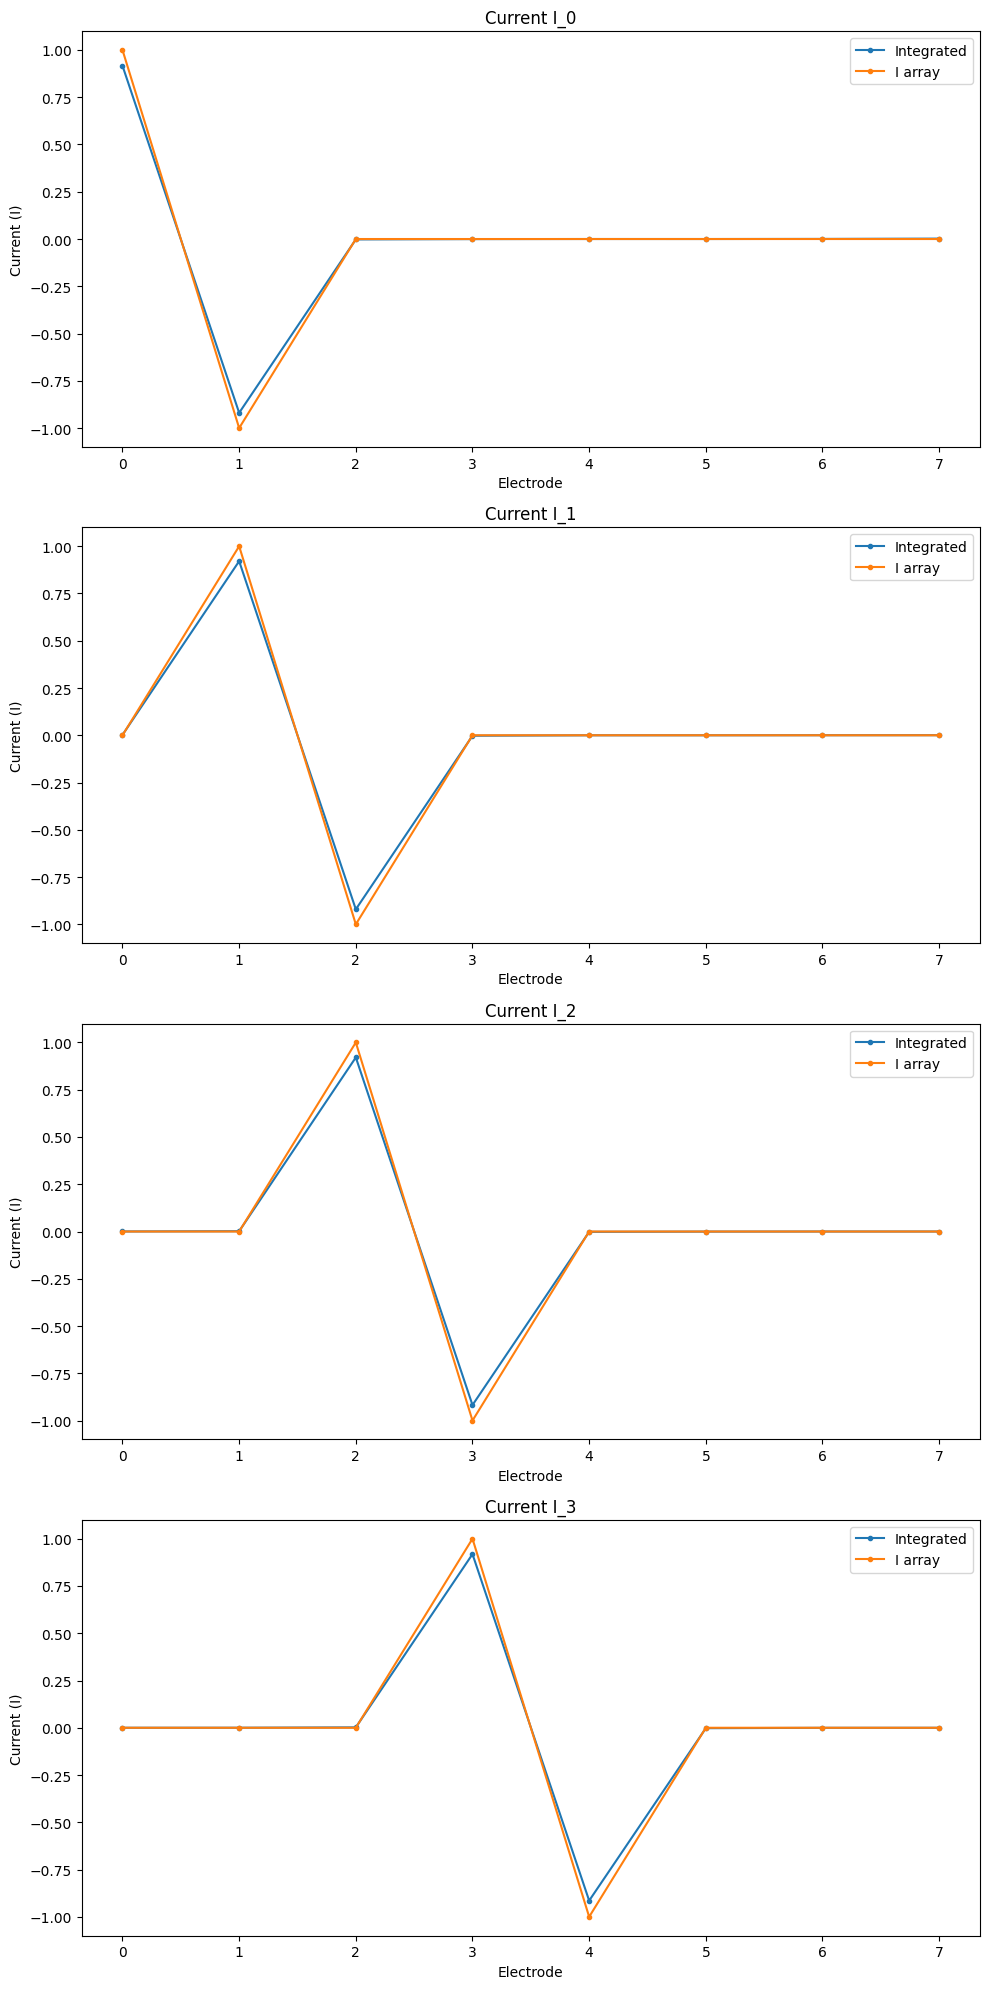

In [54]:
fig,ax = plt.subplots(l,1,figsize=(10,20))

for k in range(l):
  ax[k].plot(int_array[k].real, label="Integrated",marker='.')
  ax[k].plot(I_all[k], label="I array",marker='.')
  ax[k].legend()
  ax[k].set_ylabel("Current (I)")
  ax[k].set_xlabel("Electrode")
  ax[k].set_title(f"Current I_{k}")

fig.tight_layout()
plt.show()

#### Test 2: flux in gaps

Verifying plot of $\gamma \nabla u \cdot \eta$ on boundary

Couldn't use the fenics projections, computing it using analytic geometry stuff.

Getting index of triangles with facet on boundary

Idea from https://fenicsproject.discourse.group/t/define-a-boundary-from-dg-elements/5723/2

In [55]:
# The code below gets all triangles with a facet (edge) contained in boundary.
mesh.topology.create_connectivity(1, mesh.topology.dim)
facet_to_cell = mesh.topology.connectivity(1, mesh.topology.dim)
def boundary_locator(x):
    return np.isclose(x[0]**2+x[1]**2, 1)

boundary_facets = dolfinx.mesh.locate_entities(mesh, 1, boundary_locator)
boundary_cells = []
for facet in boundary_facets:
    boundary_cells.append(facet_to_cell.links(facet))
boundary_cells = np.hstack(boundary_cells)

In [56]:
adjacency_list = mesh.topology.connectivity(2,0)
mesh_vertex_index_list = []
for i in range(len(adjacency_list)):
  mesh_vertex_index_list.append(adjacency_list.links(i))

cells_coordinates_list = []
for cell_vertex_index in mesh_vertex_index_list:
  cells_coordinates_list.append(mesh.geometry.x[cell_vertex_index][:,:2])

#Compute grad(u_func)
# gradu_list = []

flux_list = []
for k in range(l):
  flux_k_list = []

  for idx in mesh_vertex_index_list:
    cell_coord = mesh.geometry.x[idx][:,:2]
    system_array = np.concatenate((cell_coord,np.ones(3).reshape(3,1)),axis=1)
    u_t = u_func_list[k].x.array[idx]
    plane_coef = np.linalg.solve(system_array, u_t)
    gradu = plane_coef[:2]
    # gradu_x, gradu_y = plane_coef[0],plane_coef[1]

    #checks outer segment, compute normal vector pointing outward the domain
    idx_interior_point = np.argmin(np.linalg.norm(cell_coord,axis=1)) #idx of vertex on interior (closer to 0)
    interior_point = cell_coord[idx_interior_point]
    bdr_point_A, bdr_point_B = np.delete(cell_coord,[idx_interior_point],axis=0)
    AB = bdr_point_B - bdr_point_A
    AI = interior_point - bdr_point_A
    t = np.vdot(AB,AI)/np.vdot(AB,AB)
    projAB = bdr_point_A + t*AB
    N = projAB - interior_point
    normal = N/np.linalg.norm(N)

    # gamma_x = gamma.x.array[idx]
    gamma_x = 1

    flux_k_list.append(gamma_x * (np.vdot(normal,gradu)))

  flux_k_array = np.array(flux_k_list)
  flux_list.append(flux_k_array)

In [57]:
#get angle of cell in each
dofs_coordinates = V0.tabulate_dof_coordinates()
x_bdr = dofs_coordinates[boundary_cells][:,0]
y_bdr = dofs_coordinates[boundary_cells][:,1]
theta = np.where(y_bdr>=0,np.arccos(x_bdr),2*np.pi - np.arccos(x_bdr))

In [58]:
#checks if angle is in some electrode
electrode_marker = []
for angle in theta:
  inElectrode = False
  for (theta_i,theta_f) in electrodes.position:
    if theta_i<=angle and angle<=theta_f:
      inElectrode = True
      break
  electrode_marker.append(inElectrode)

electrode_marker = np.array(electrode_marker)

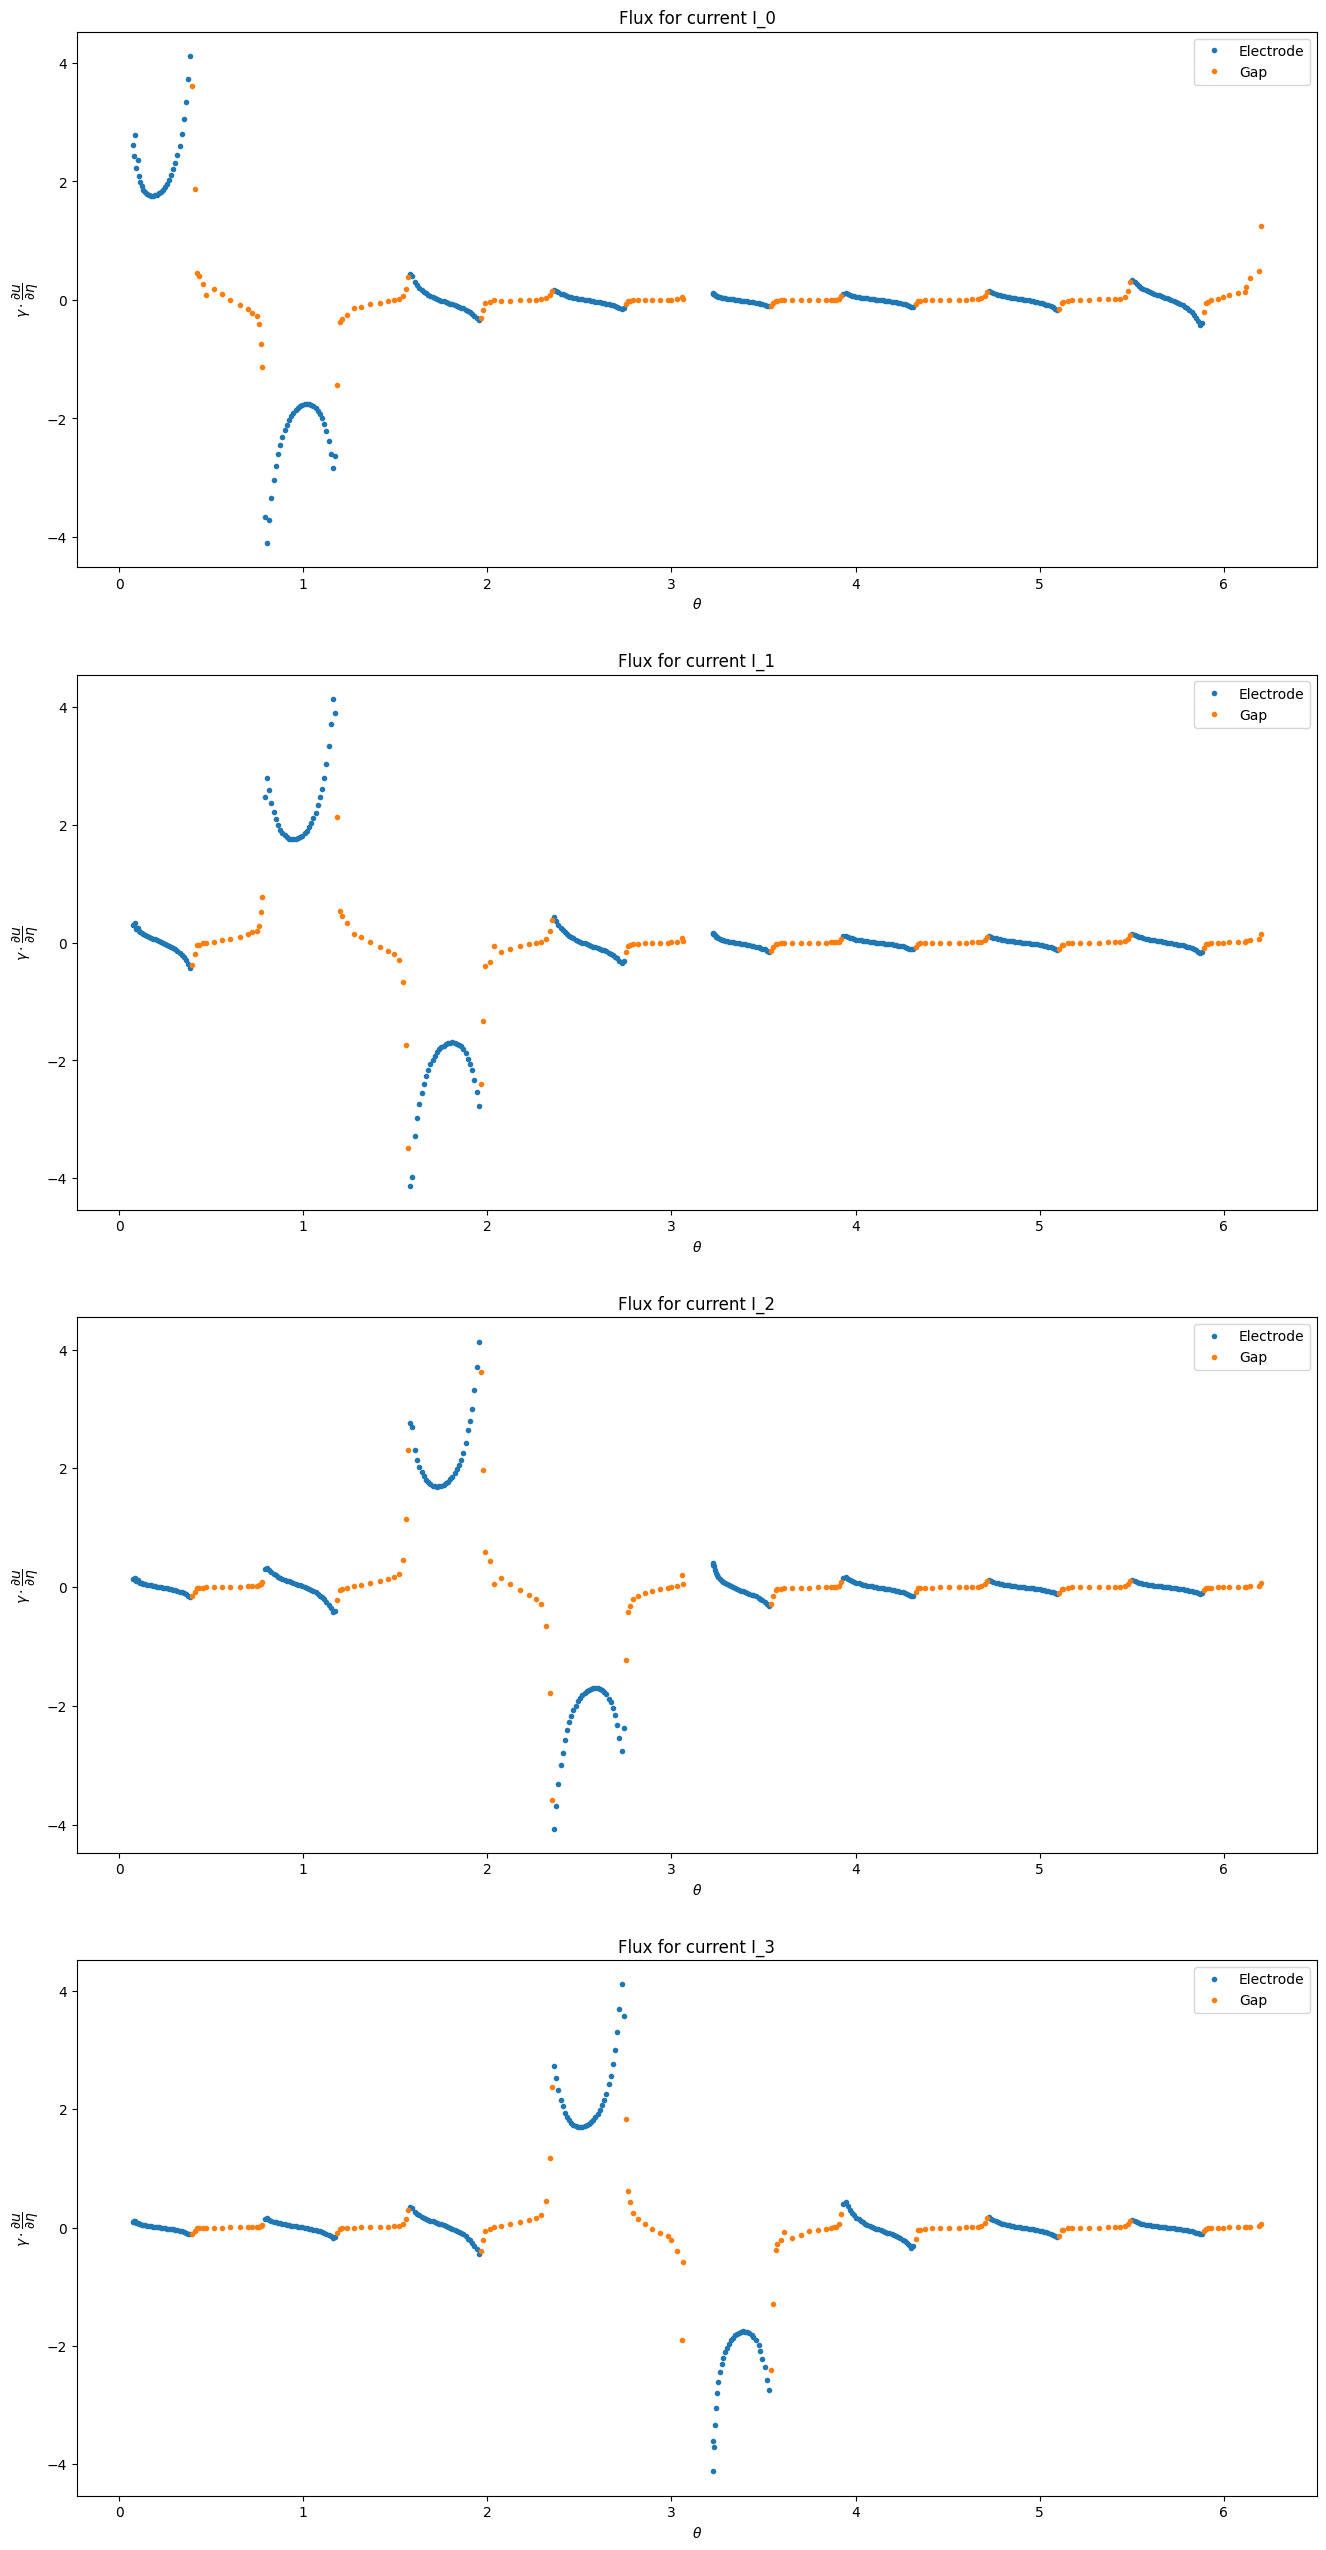

In [59]:
fig,ax = plt.subplots(l,1,figsize=(16,32))


for k in range(l):
  flux_array = flux_list[k]
  theta_cells_in_electrode = theta[electrode_marker]
  theta_cells_out_electrode = theta[~electrode_marker]
  flux_in_electrode = flux_array[boundary_cells][electrode_marker]
  flux_out_electrode = flux_array[boundary_cells][~electrode_marker]


  ax[k].plot(theta_cells_in_electrode,flux_in_electrode.real,marker='.',linestyle='',label="Electrode")
  ax[k].plot(theta_cells_out_electrode,flux_out_electrode.real,marker='.',linestyle='',label='Gap')
  ax[k].set_xlabel("$\\theta$")
  ax[k].set_ylabel("$\gamma \cdot \dfrac{\partial u}{\partial \eta}$")
  ax[k].legend()
  ax[k].set_title(f'Flux for current I_{k}')

plt.show()

#### Test 3: potential in electrodes

Testing if
$$
U_j = u|_{e_j} + z_j \gamma \frac{\partial u}{\partial \eta}
$$


As $u$ is defined on the vertices and $\gamma \frac{\partial u}{\partial \eta}$ is constant in each edge, needs to chose which vertex and adjacent facet to evaluate.

Getting the following:
- order vertices and facets by angle;
- chose $u_j$ and $\gamma_j$ in the order set above.



In [60]:
#create connection
mesh.topology.create_connectivity(mesh.topology.dim-1, mesh.topology.dim)
boundary_facets = dolfinx.mesh.exterior_facet_indices(mesh.topology)
boundary_dofs_index_array = dolfinx.fem.locate_dofs_topological(V, mesh.topology.dim-1, boundary_facets) #array with the vertices index

#gets x and y coordinates for the boundary
V_dofs_coordinates = V.tabulate_dof_coordinates()
x_bdr = V_dofs_coordinates[boundary_dofs_index_array][:,0]
y_bdr = V_dofs_coordinates[boundary_dofs_index_array][:,1]
theta = np.where(y_bdr>=0,np.arccos(x_bdr),2*np.pi - np.arccos(x_bdr))
sorted_theta_vtx_index = np.argsort(theta)

#get angle of cell in each
V0_dofs_coordinates = V0.tabulate_dof_coordinates()
x_bdr = V0_dofs_coordinates[boundary_cells][:,0]
y_bdr = V0_dofs_coordinates[boundary_cells][:,1]
theta_cells = np.where(y_bdr>=0,np.arccos(x_bdr),2*np.pi - np.arccos(x_bdr))
sorted_theta_cll_index = np.argsort(theta_cells)


In [61]:
sorted_bdr_vtx_idx = boundary_dofs_index_array[sorted_theta_vtx_index]
sorted_bdr_cll_idx = boundary_cells[sorted_theta_cll_index]
U_star_list = []
for k in range(l):
  flux_array = flux_list[k]
  U_star = u_func_list[k].x.array[sorted_bdr_vtx_idx] + z_value*flux_array[sorted_bdr_cll_idx]
  U_star_list.append(U_star)

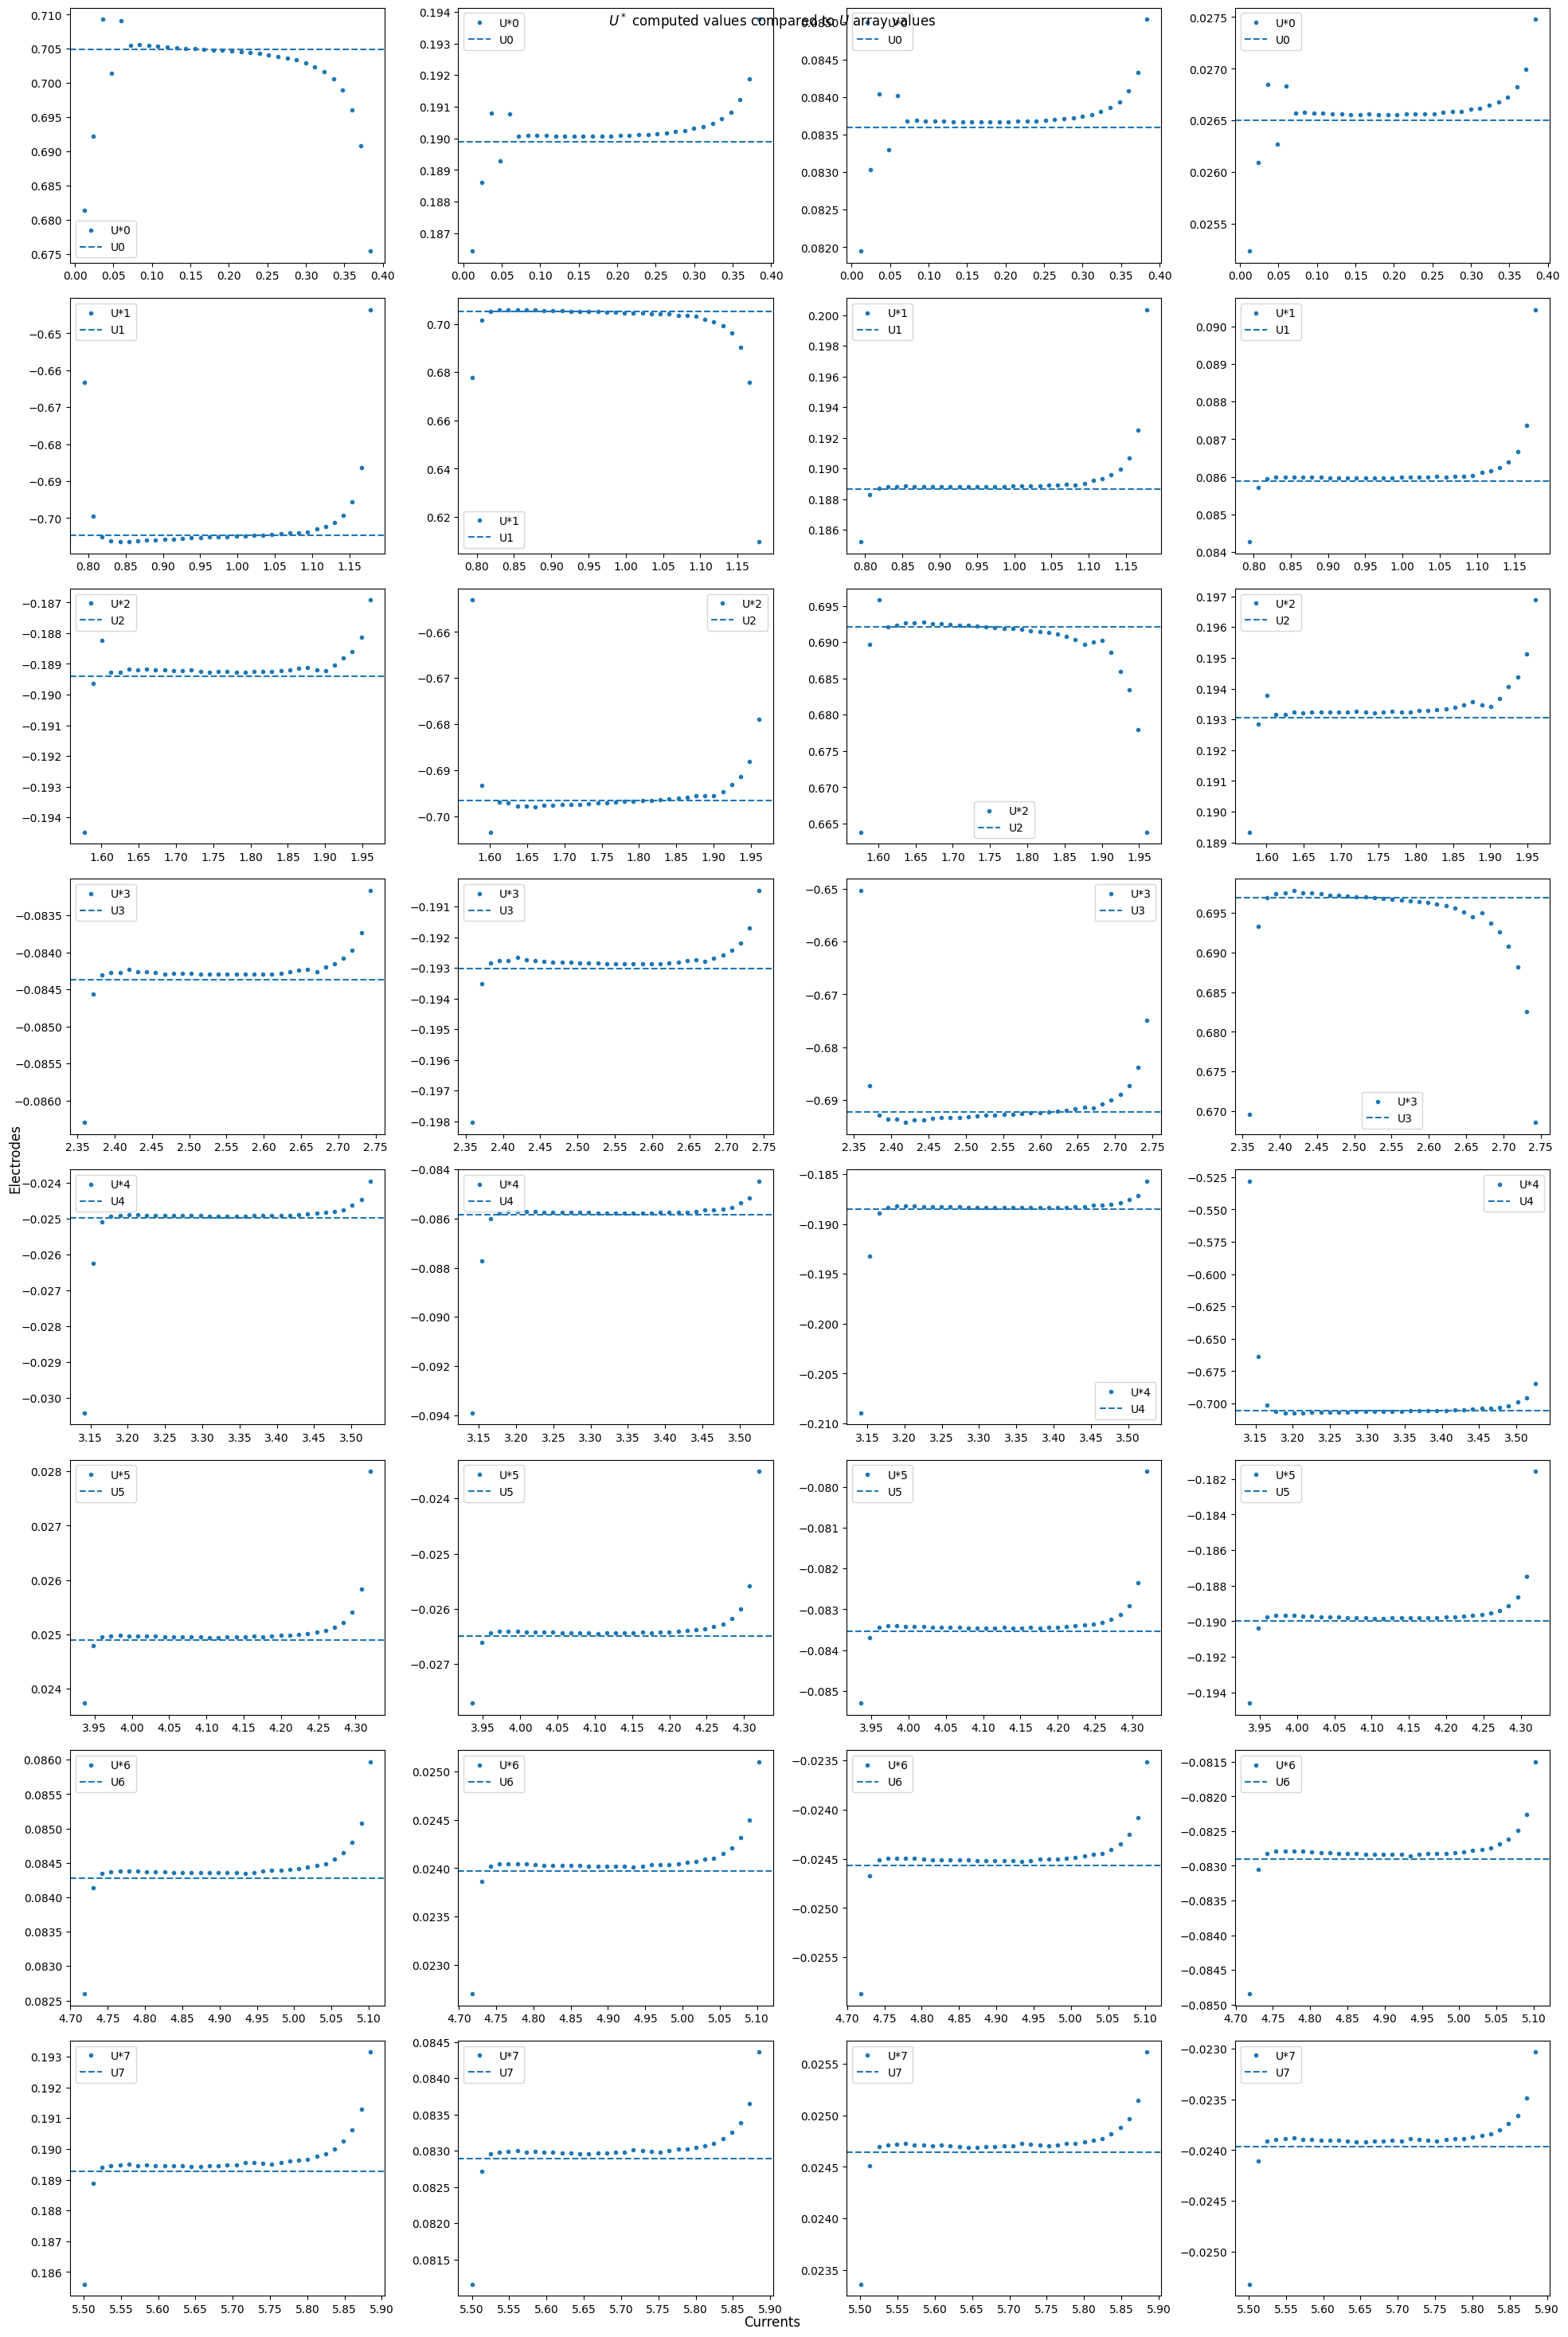

In [62]:
t = theta[sorted_theta_vtx_index]
fig,axs = plt.subplots(L,l,figsize=(20,30))

for k in range(l):
  U_star = U_star_list[k]
  U_array = U_array_list[k]

  for j in range(L):
    theta_i,theta_f = electrodes.position[j]
    theta_j_idx = np.logical_and(t>=theta_i,t<=theta_f)#index of theta in electrode j
    axs[j][k].plot(t[theta_j_idx],U_star.real[theta_j_idx],label=f"U*{j}",linestyle='',marker='.')
    axs[j][k].axhline(U_array[j].real,label=f'U{j}',linestyle='--')
    axs[j][k].legend()
    # axs[j].set_xticks(np.linspace(0,2*np.pi,5),["0","$\\frac{\pi}{2}$","$\pi$","$\\frac{3\pi}{2}$","$2\pi$"])

    # axs[1].plot(t,f(t),label="exact")
    # axs[1].plot(t,u_bdr_imag_array,label="calculated")
    # axs[1].set_title("imaginary part")
    # axs[1].set_xticks(np.linspace(0,2*np.pi,5),["0","$\\frac{\pi}{2}$","$\pi$","$\\frac{3\pi}{2}$","$2\pi$"])
fig.suptitle("$U^*$ computed values compared to $U$ array values")
fig.supylabel("Electrodes")
fig.supxlabel("Currents")

fig.tight_layout()

plt.show()

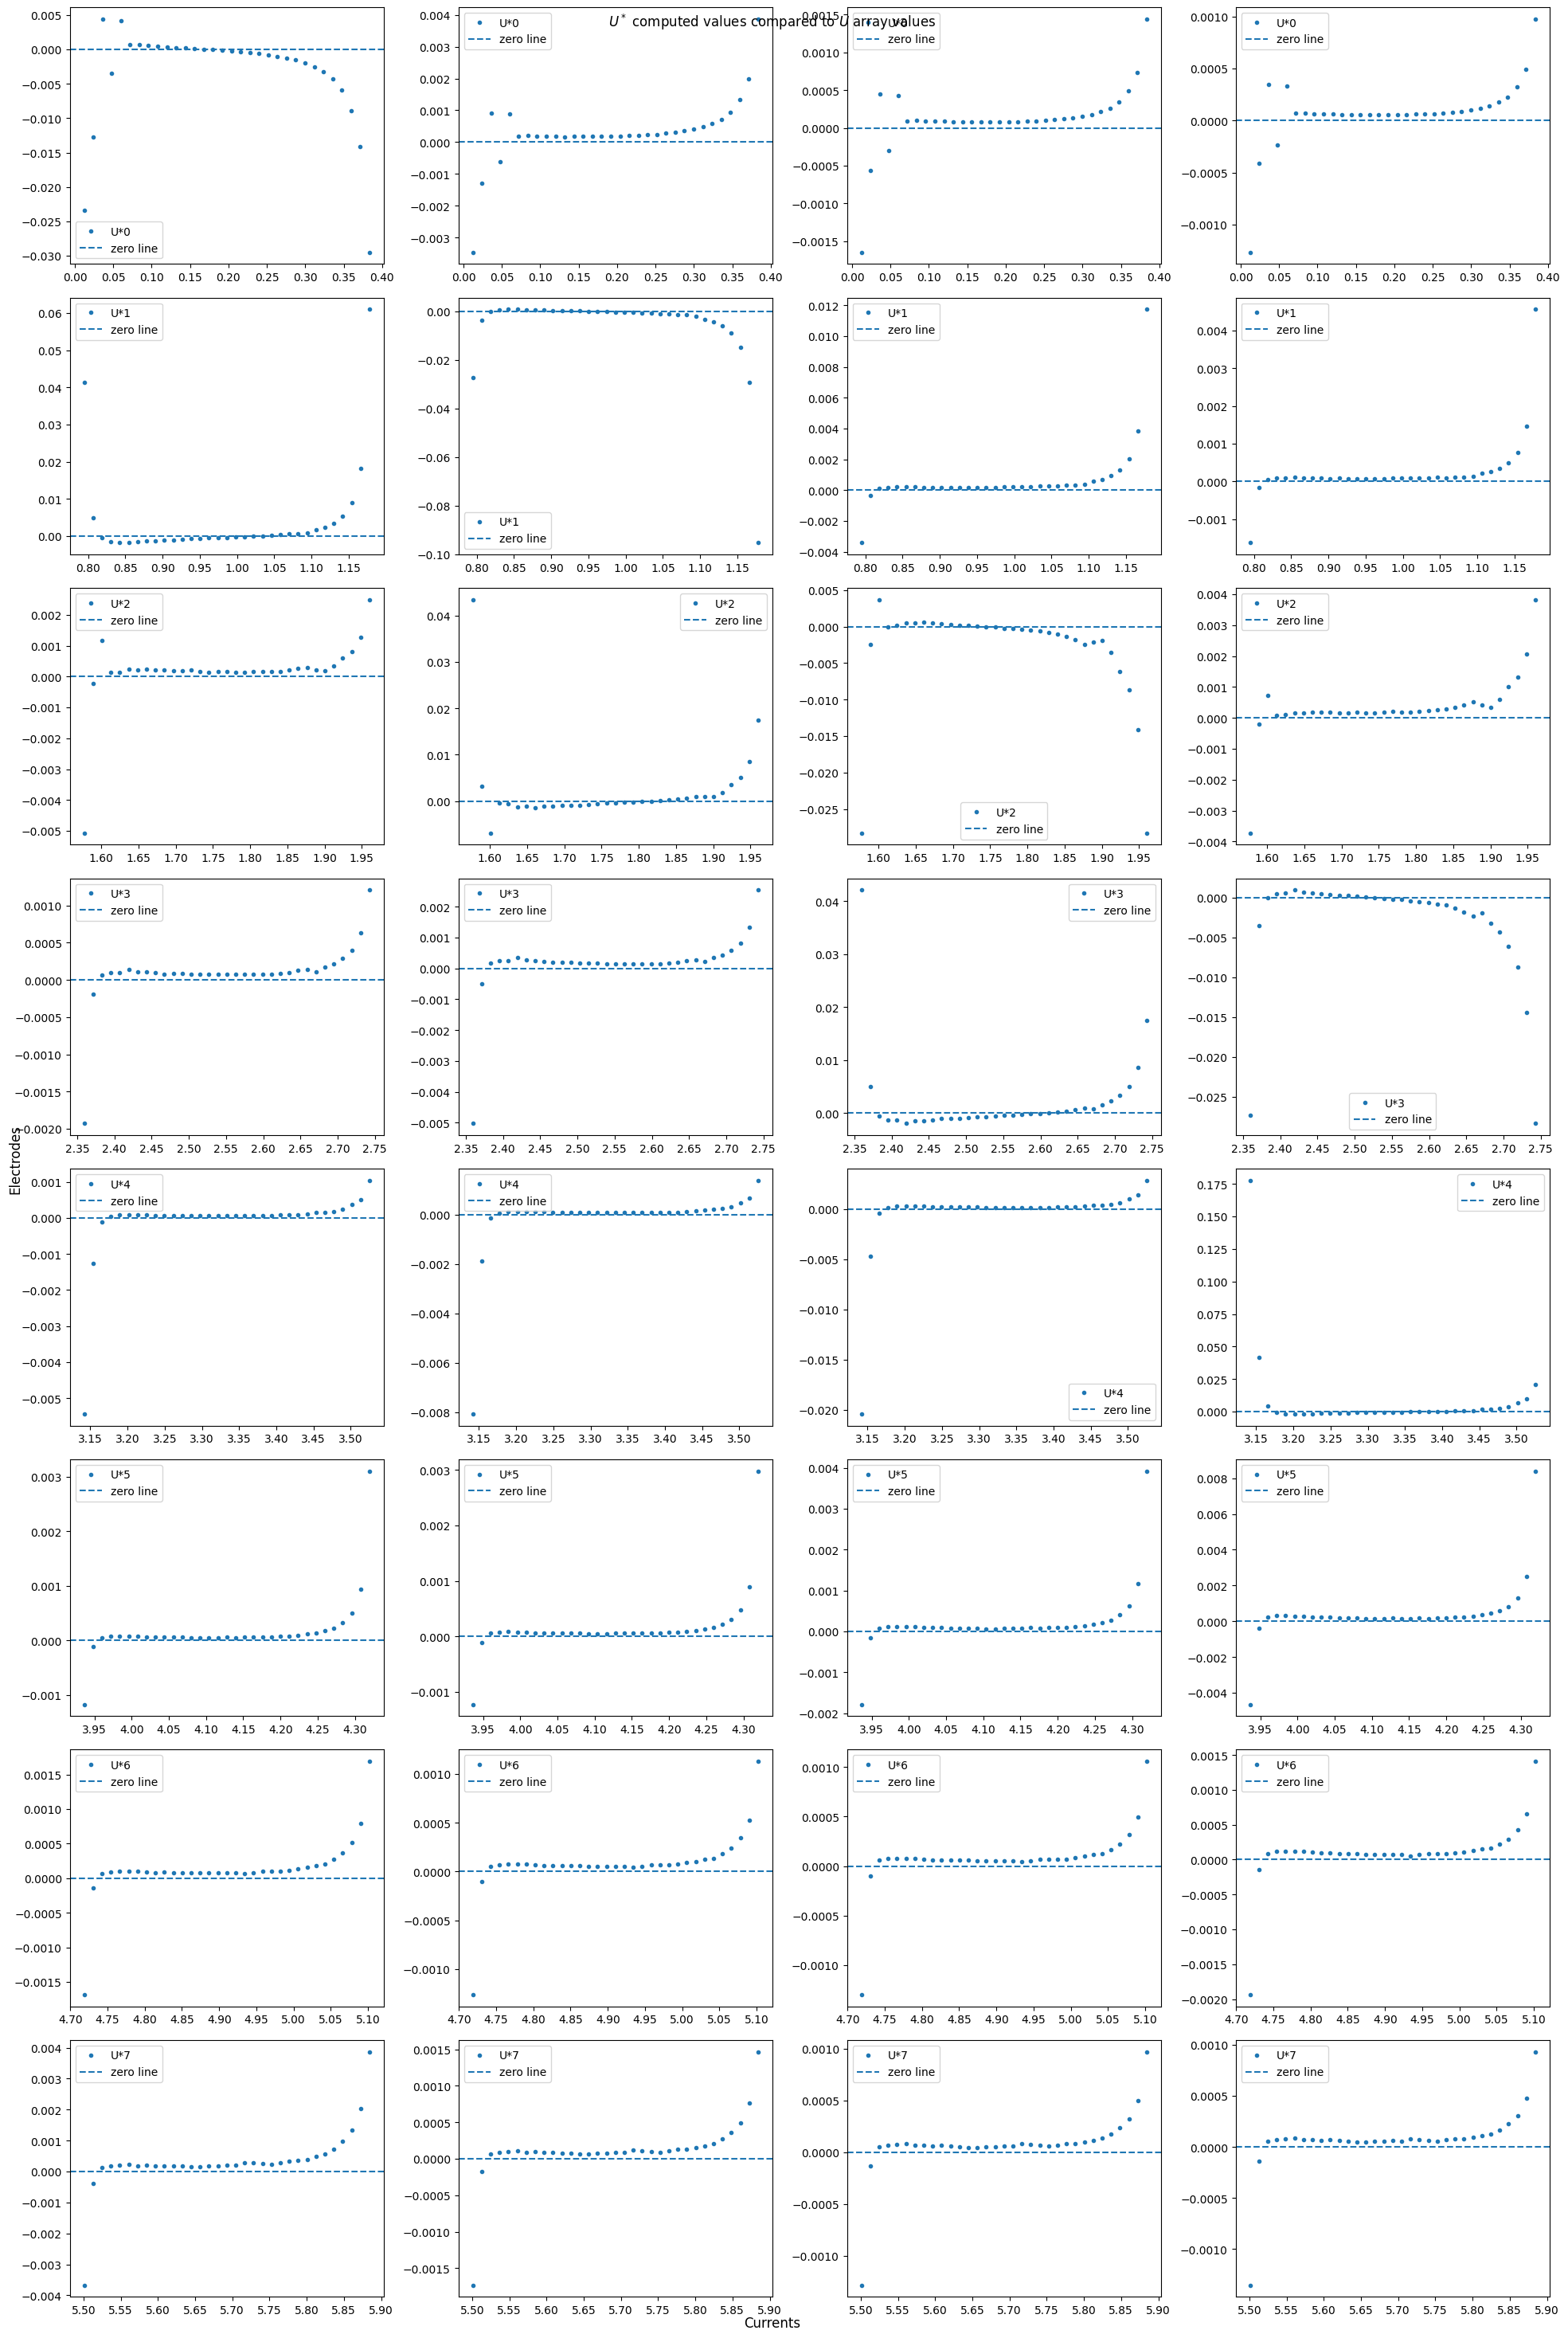

In [63]:
t = theta[sorted_theta_vtx_index]
fig,axs = plt.subplots(L,l,figsize=(20,30))

for k in range(l):
  U_star = U_star_list[k]
  U_array = U_array_list[k]

  for j in range(L):
    theta_i,theta_f = electrodes.position[j]
    theta_j_idx = np.logical_and(t>=theta_i,t<=theta_f)#index of theta in electrode j
    # axs[j][k].plot(t[theta_j_idx],U_star.real[theta_j_idx],label=f"U*{j}",linestyle='',marker='.')
    # axs[j][k].axhline(U_array[j].real,label=f'U{j}',linestyle='--')
    axs[j][k].plot(t[theta_j_idx],U_star.real[theta_j_idx]-U_array[j].real,label=f"U*{j}",linestyle='',marker='.')
    axs[j][k].axhline(0,label=f'zero line',linestyle='--')
    axs[j][k].legend()
    # axs[j].set_xticks(np.linspace(0,2*np.pi,5),["0","$\\frac{\pi}{2}$","$\pi$","$\\frac{3\pi}{2}$","$2\pi$"])

    # axs[1].plot(t,f(t),label="exact")
    # axs[1].plot(t,u_bdr_imag_array,label="calculated")
    # axs[1].set_title("imaginary part")
    # axs[1].set_xticks(np.linspace(0,2*np.pi,5),["0","$\\frac{\pi}{2}$","$\pi$","$\\frac{3\pi}{2}$","$2\pi$"])
fig.suptitle("$U^*$ computed values compared to $U$ array values")
fig.supylabel("Electrodes")
fig.supxlabel("Currents")

fig.tight_layout()

plt.show()

## Solving by PETSc

In [64]:
# Assembling matrix A
A = PETSc.Mat()
A.createNest([[A1_matrix,     A2_matrix],
              [A2_matrix.transpose(), A4_matrix]])
A.setUp()
A.assemble()

In [109]:

#Assembling b vector
I_vec = PETSc.Vec().create(comm=MPI.COMM_WORLD)
I_vec.setSizes(L)
I_vec.setUp()
I_vec.setArray(I)
# I_vec.setValues(range(N+1,N+L+1),I)
I_vec.assemble()

zero_vec = PETSc.Vec().create(comm=MPI.COMM_WORLD)
zero_vec.setSizes(N)
zero_vec.setUp()
zero_vec.setArray(np.zeros(N))
# zero_vec.setValues(range(N+1,N+L+1),I)
zero_vec.assemble()

b_nested = PETSc.Vec()
b_nested.createNest([zero_vec,I_vec])
b_nested.setUp()


TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [ ]:
# Solving problem

#Create solution vector
u_vec = PETSc.Vec().create(comm=MPI.COMM_WORLD)
u_vec.setSizes(N)
U_vec = PETSc.Vec().create(comm=MPI.COMM_WORLD)
U_vec.setSizes(L)
u_vec.setUp()
U_vec.setUp()
u_nested = PETSc.Vec().create(comm=MPI.COMM_WORLD)
u_nested.createNest([u_vec, U_vec]) #x0 and x1 are petsc vectors for your solution
u_nested.setUp()

ksp = PETSc.KSP().create(mesh.comm)
ksp.setType(PETSc.KSP.Type.CG)
ksp.setTolerances(rtol=1e-14)
ksp.setOperators(A)
ksp.setFromOptions()
ksp.solve(b_nested,u_nested)

# ksp = PETSc.KSP().create(mesh.comm)
# ksp.setOperators(A)
# ksp.setType("cg")
# ksp.setTolerances(rtol=1e-9)
# ksp.getPC().setType("fieldsplit")
# ksp.getPC().setFieldSplitType(PETSc.PC.CompositeType.ADDITIVE)

Error: error code 60
[0] KSPSolve() at /tmp/petsc-src/src/ksp/ksp/interface/itfunc.c:1082
[0] KSPSolve_Private() at /tmp/petsc-src/src/ksp/ksp/interface/itfunc.c:910
[0] KSPSolve_CG() at /tmp/petsc-src/src/ksp/ksp/impls/cg/cg.c:248
[0] KSP_MatMult() at /tmp/petsc-src/include/petsc/private/kspimpl.h:347
[0] MatMult() at /tmp/petsc-src/src/mat/interface/matrix.c:2608
[0] MatMult_Nest() at /tmp/petsc-src/src/mat/impls/nest/matnest.c:51
[0] MatMultAdd() at /tmp/petsc-src/src/mat/interface/matrix.c:2770
[0] Nonconforming object sizes
[0] Mat mat,Vec v1: global dim 1056 16

# Extra tests

## Theta paramether location

In [ ]:
t = np.linspace(0,2*np.pi,40)
x = np.array([np.cos(t),np.sin(t)])
np.where(theta(x)>=electrodes.position[14][0],1,0)
boundaries =[
    (i, lambda x,i=i: np.where(theta(x)>=electrodes.position[i][0],1,0))
    for i in range(L)
]
boundaries[1][1](x)